In [2]:
import glob, os, shutil
import numpy as np
from sklearn import preprocessing
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

#from feos.si import *

from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem

from gnn_dataset import dataset, minmax_to_json, minmax_from_json

In [3]:
savepath = "initial_study/"

msize=12
mwidth = 2
fsize=16
alpha=0.7
lsize = 2    
framewidth = 3

In [4]:

data_csv = "ini_data/13321_2024_820_MOESM2_ESM_raw.csv"
data = pd.read_csv(data_csv)

data = data.rename(columns={"CANON_SMILES": "canonical_smiles", "Temperature (K)": "temperature",
                           "Name": "iupac_name",# "Temperature (K)": "temperature"
                           })
data["isomeric_smiles"] = data["canonical_smiles"]

data["pressure"] = 101325
data["phase"] = "Liquid"
data["MD_density"] = data["MD_density"]*1000
data["viscosity"] = data["Viscosity (cP)"]*0.001
data["log_viscosity"] = np.log(data["viscosity"])
data["MD_HV"] *= 4184.0

ff = lambda x: Descriptors.MolWt(AllChem.MolFromSmiles(x["canonical_smiles"]))/1000
data["molarweight"] = data.apply(ff, axis=1)

data["volume"] = 1 / (data["MD_density"]  / (data["molarweight"]) )
data["family"] = "battery solvents"
data["dE"] = data["MD_HV"] + data["volume"]*data["pressure"] - 8.314*data["temperature"]
data["dE_RT"] = data["dE"] / data["temperature"] / 8.314
data["dE_nRT"] = data["dE"] / data["temperature"] / 8.314 / 4 # default n=4 (chain molecule)
data["a"] = 1.090e-3*data["molarweight"]**0.5*data["temperature"]**(3/2) / (data["volume"]**(2/3)*data["dE"]  )
data["log_a"] = np.log(data["a"])
data["a00"] = 4.99+2.73
data["log_value"] = data["log_viscosity"] - data["log_a"] + data["a00"]
data["value"] = np.exp(data["log_value"])

data.keys()


Index(['Index', 'iupac_name', 'canonical_smiles', 'temperature',
       'Inverse temperature (1/K)', 'Viscosity (cP)', 'log(Viscosity)',
       'MD_density', 'MD_FV', 'MD_Rg', 'MD_SP_E', 'MD_SP_V', 'MD_SP', 'MD_HV',
       'MD_RMSD', 'Reference', 'isomeric_smiles', 'pressure', 'phase',
       'viscosity', 'log_viscosity', 'molarweight', 'volume', 'family', 'dE',
       'dE_RT', 'dE_nRT', 'a', 'log_a', 'a00', 'log_value', 'value'],
      dtype='object')

In [5]:
len(np.unique(data["canonical_smiles"]))

957

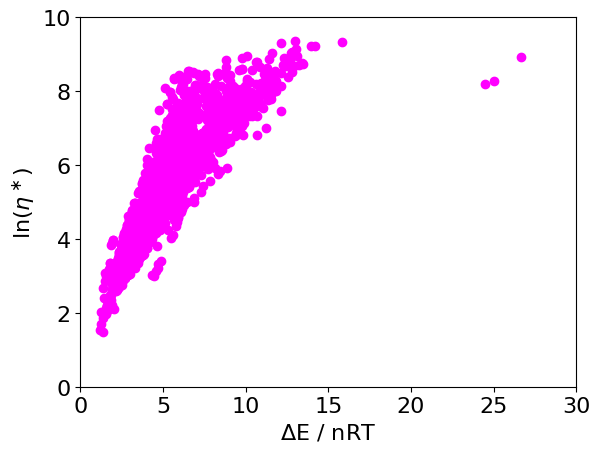

In [6]:
plt.plot(data["dE_nRT"], data["log_value"], ".",markersize=msize,color="magenta")

plt.xlim([0,30])
plt.ylim([0,10])

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  
#plt.legend(fontsize=fsize,frameon=False)
plt.xlabel(r"$\Delta$E / nRT",fontsize=fsize)  
plt.ylabel(r"ln($\eta^\ast$)",fontsize=fsize)  

plt.savefig(savepath+"log_value_dE_nRT.png",bbox_inches='tight')
plt.savefig(savepath+"log_value_dE_nRT.pdf",bbox_inches='tight')
plt.show()
plt.close()    

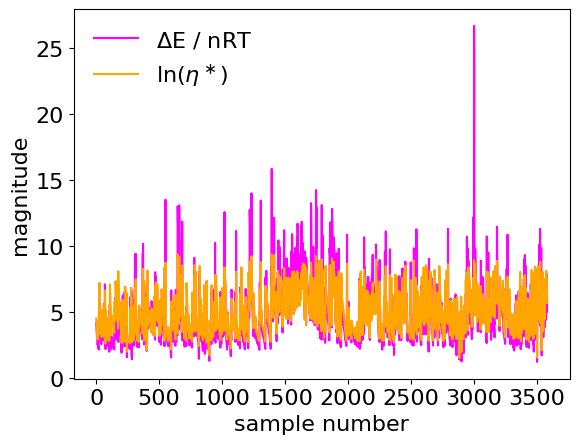

In [7]:
"""
data["a00"] is used to overlap log_value and dE_nRT !!!
"""
plt.plot(data["dE_nRT"],markersize=msize, label=r"$\Delta$E / nRT",color="magenta")
plt.plot(data["log_value"],markersize=msize, label=r"ln($\eta^\ast$)",color="orange")

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  
plt.legend(fontsize=fsize,frameon=False)
plt.xlabel(r"sample number",fontsize=fsize)  
plt.ylabel(r"magnitude",fontsize=fsize)  

plt.savefig(savepath+"log_value_dE_nRT_sample.png",bbox_inches='tight')
plt.savefig(savepath+"log_value_dE_nRT_sample.pdf",bbox_inches='tight')
plt.show()
plt.close()    

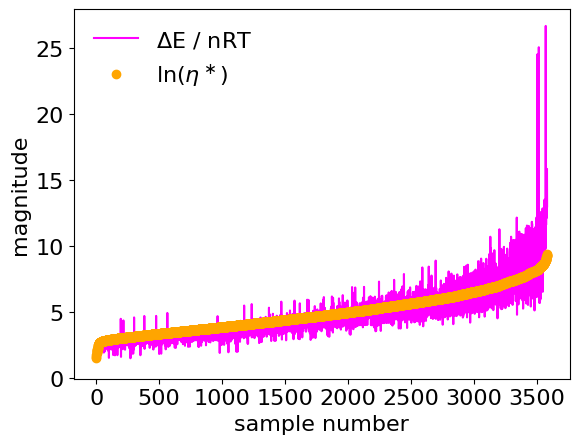

In [8]:
a = np.array(data["log_value"])
p = np.argsort(a)
a = a[p]
b = np.array(data["dE_nRT"])[p]
plt.plot(b,markersize=msize, label=r"$\Delta$E / nRT",color="magenta")
plt.plot(a,".",markersize=msize, label=r"ln($\eta^\ast$)",color="orange")

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  
plt.legend(fontsize=fsize,frameon=False)
plt.xlabel(r"sample number",fontsize=fsize)  
plt.ylabel(r"magnitude",fontsize=fsize)  

plt.savefig(savepath+"log_value_dE_nRT_sample_sort.png",bbox_inches='tight')
plt.savefig(savepath+"log_value_dE_nRT_sample_sort.pdf",bbox_inches='tight')
plt.show()
plt.close()  

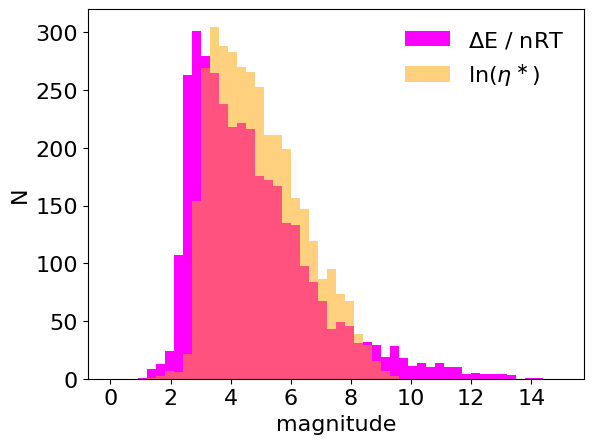

In [9]:
"""
data["a00"] is used to overlap log_value and dE_nRT !!!
"""
plt.hist(data["dE_nRT"],50, range=[0,15],label=r"$\Delta$E / nRT",color="magenta")
plt.hist(data["log_value"],50, range=[0,15], label=r"ln($\eta^\ast$)", alpha=0.5,color="orange")

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  
plt.legend(fontsize=fsize,frameon=False)
plt.xlabel(r"magnitude",fontsize=fsize)  
plt.ylabel(r"N",fontsize=fsize)  

plt.savefig(savepath+"log_value_dE_nRT_dist.png",bbox_inches='tight')
plt.savefig(savepath+"log_value_dE_nRT_dist.pdf",bbox_inches='tight')
plt.show()
plt.close()  

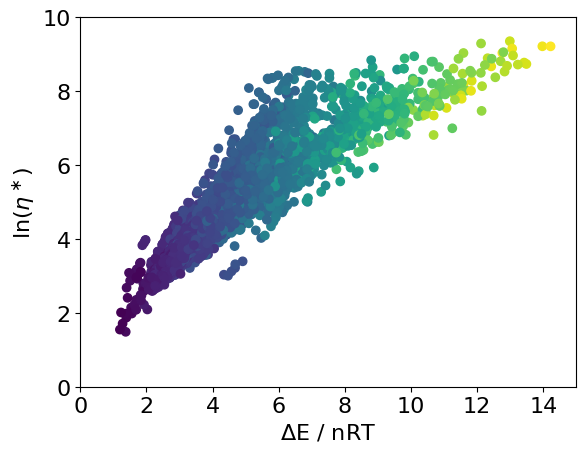

In [10]:
p = data["dE_nRT"] < 15
plt.scatter(data["dE_nRT"][p], data["log_value"][p], c=data["dE"][p])

plt.xlim([0,15])
plt.ylim([0,10])

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  
#plt.legend(fontsize=fsize,frameon=False)
plt.xlabel(r"$\Delta$E / nRT",fontsize=fsize)  
plt.ylabel(r"ln($\eta^\ast$)",fontsize=fsize)  

#plt.savefig(savepath+"log_value_dE_nRT.png",bbox_inches='tight')
#plt.savefig(savepath+"log_value_dE_nRT.pdf",bbox_inches='tight')
plt.show()
plt.close()    

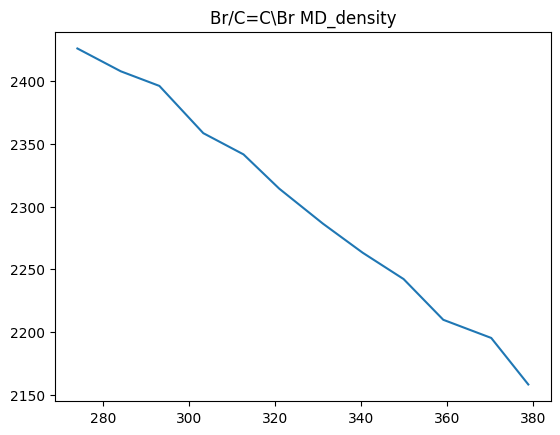

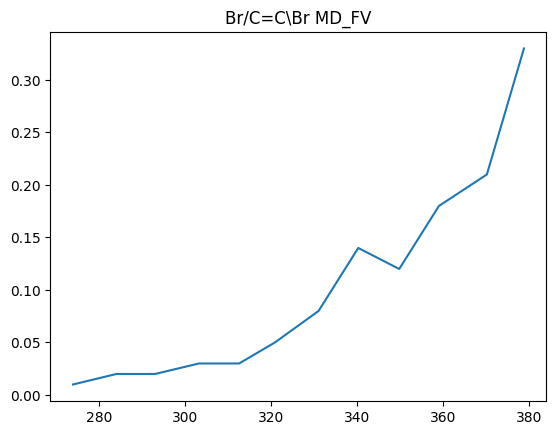

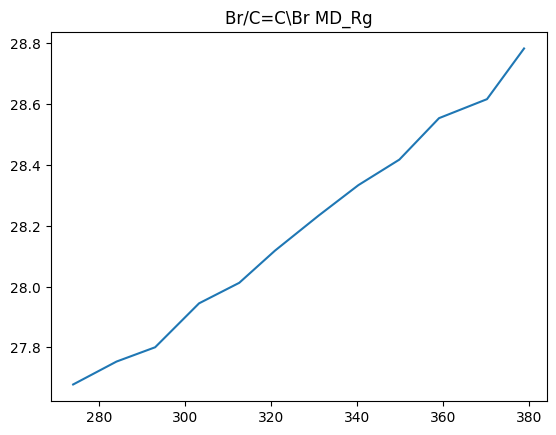

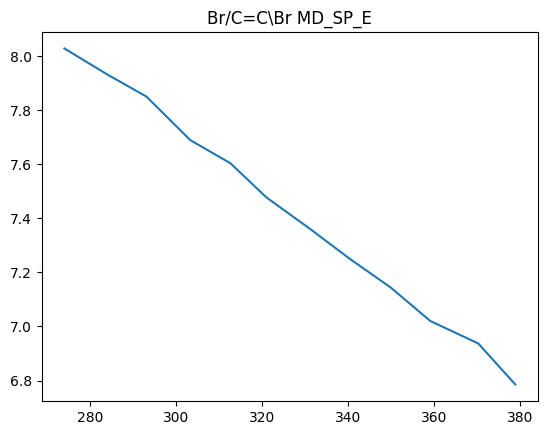

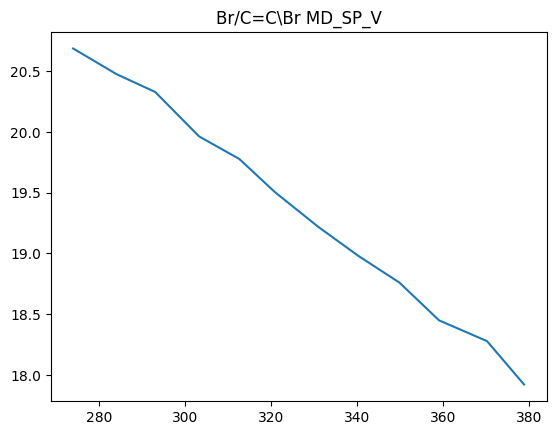

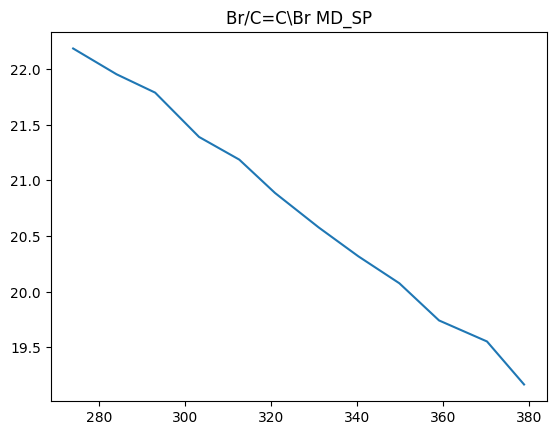

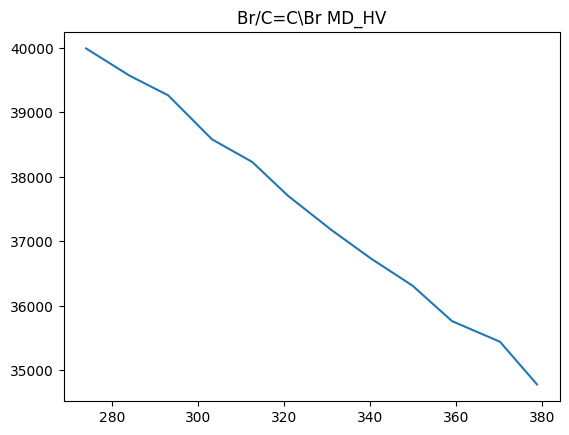

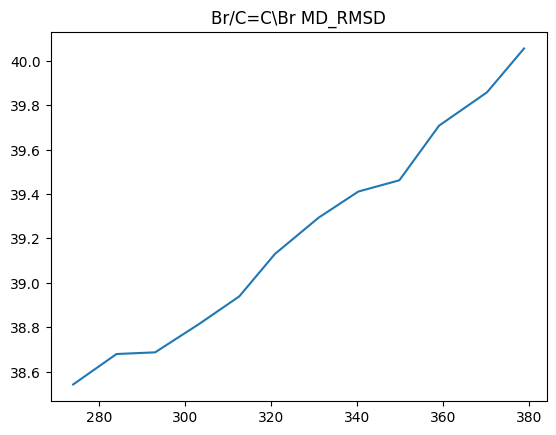

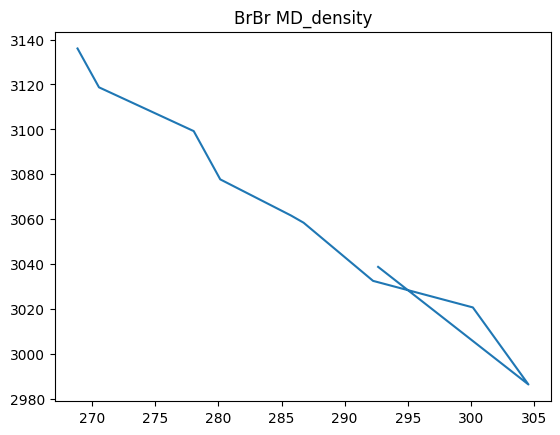

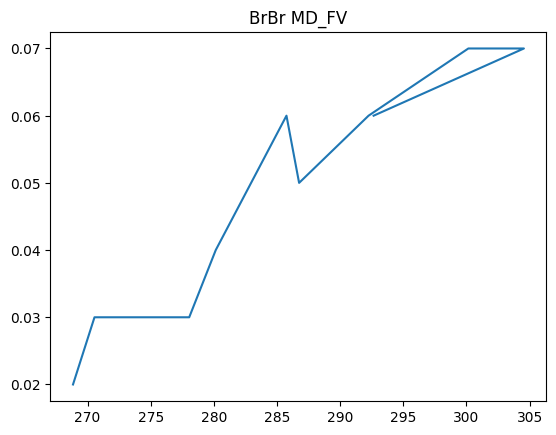

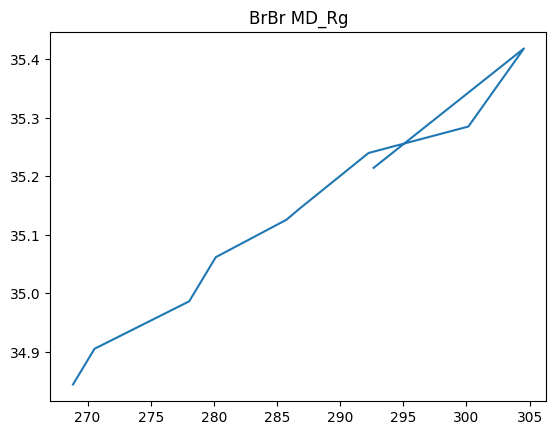

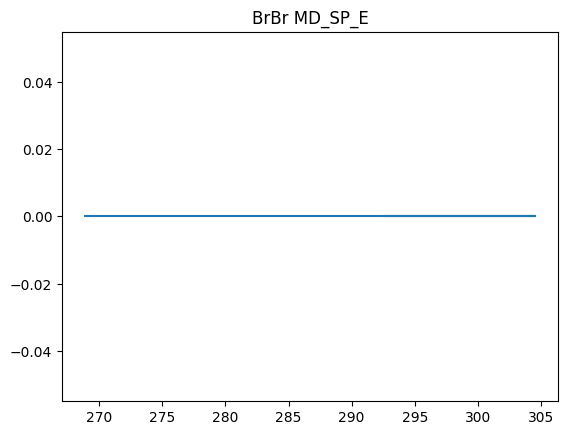

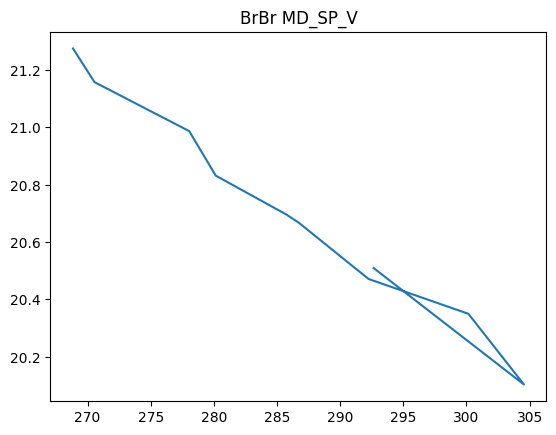

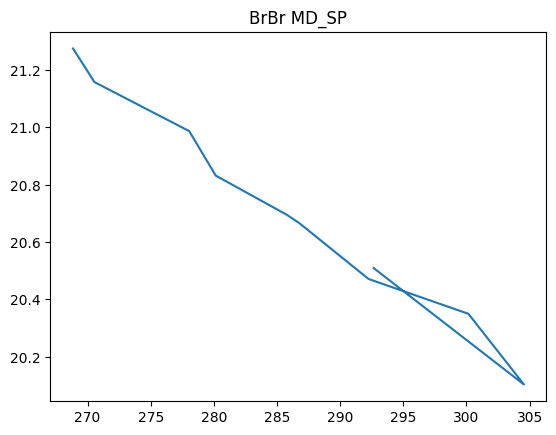

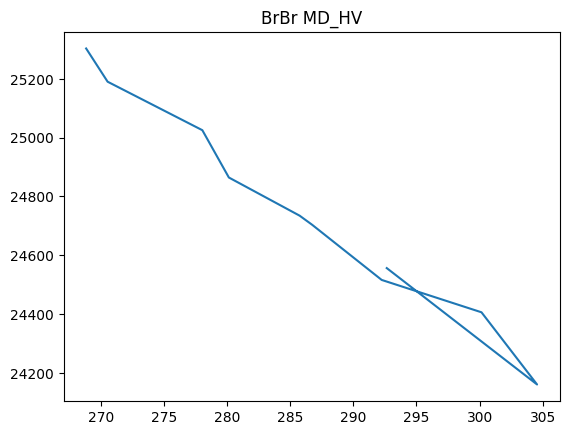

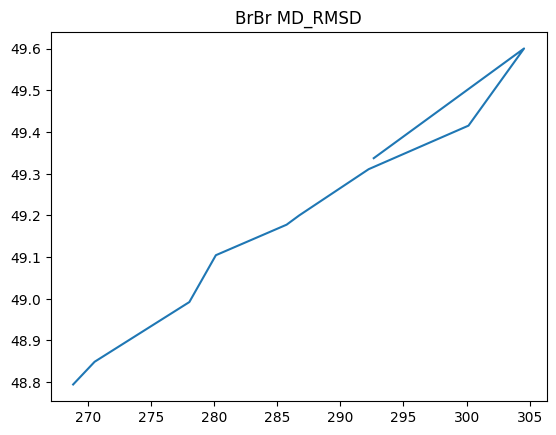

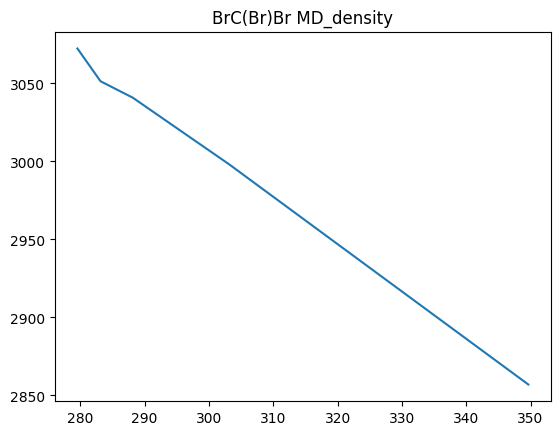

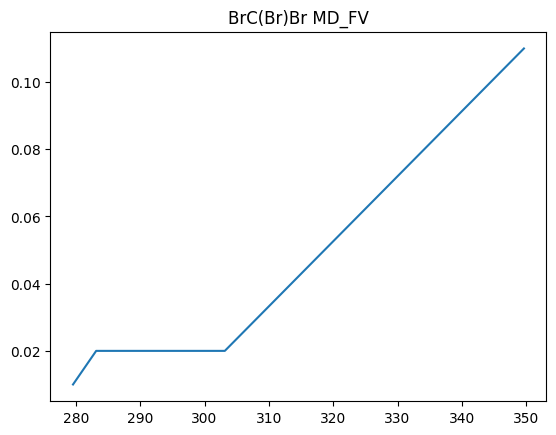

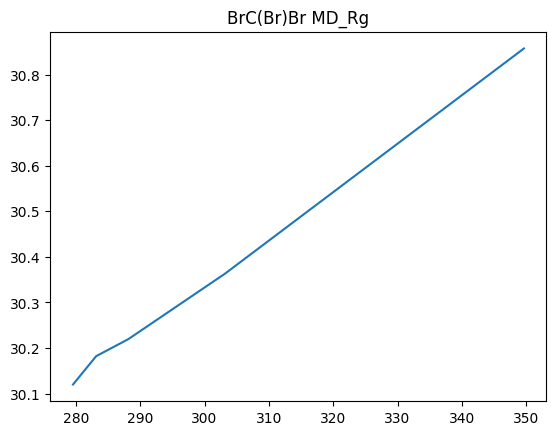

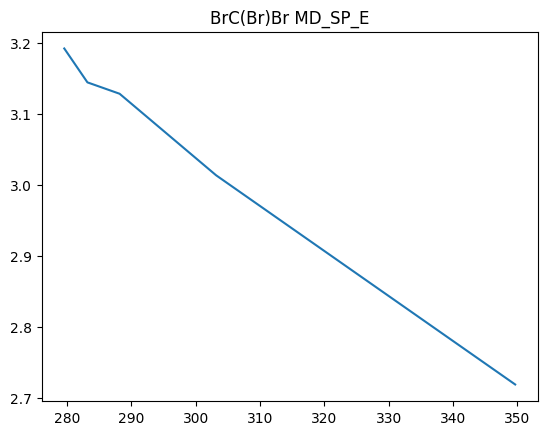

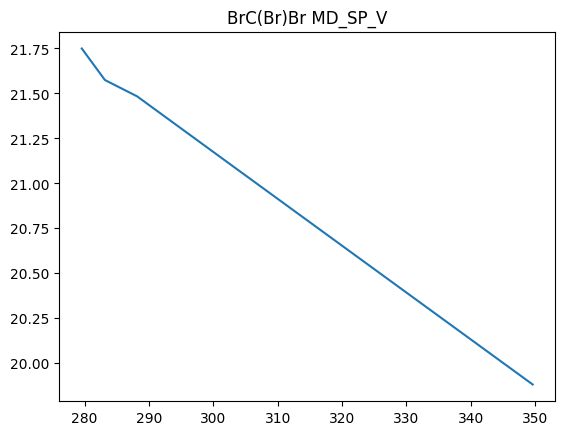

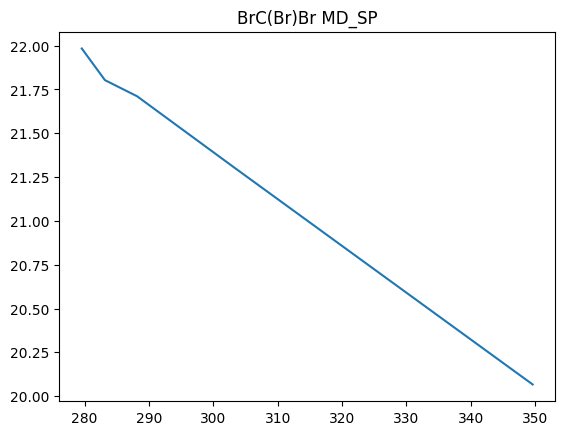

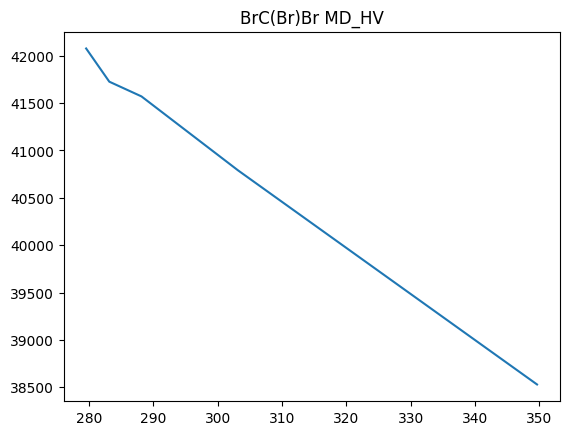

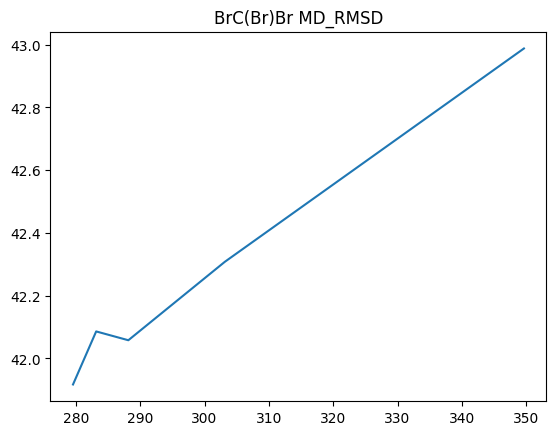

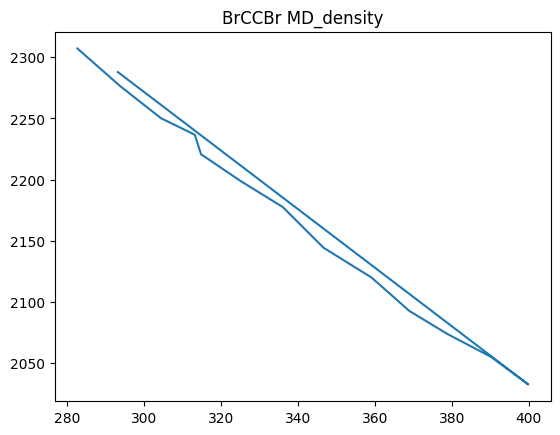

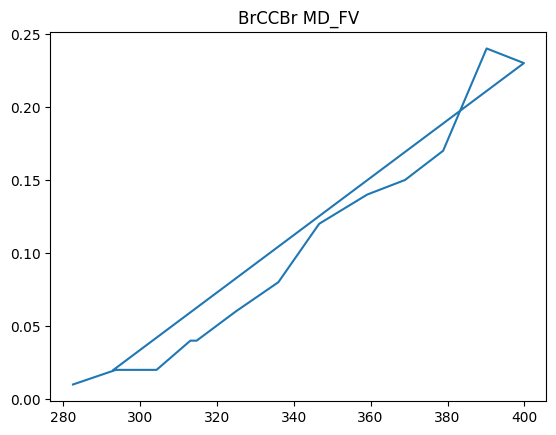

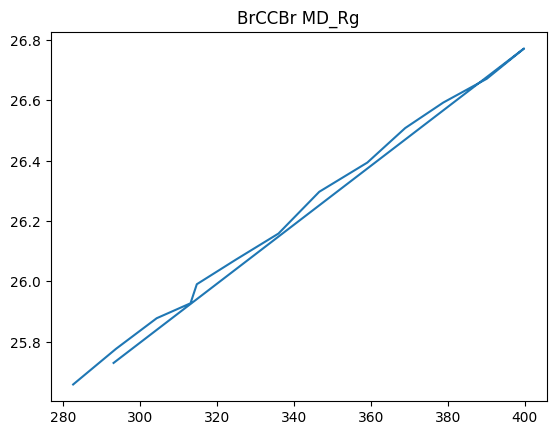

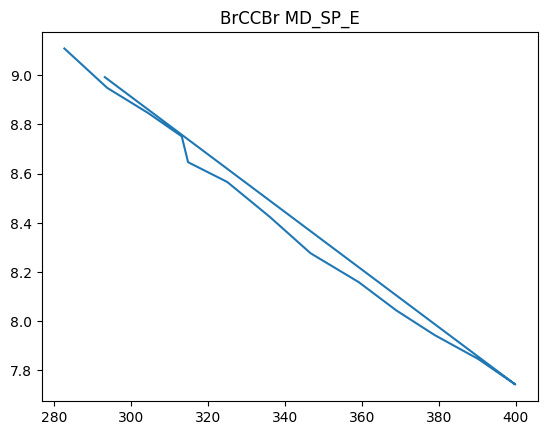

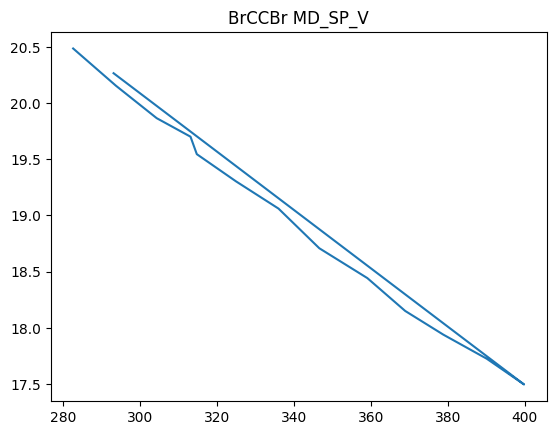

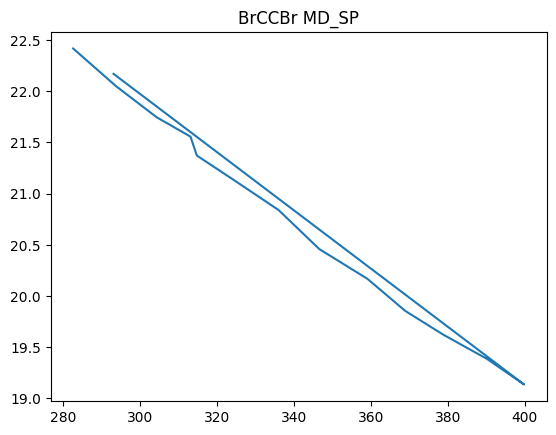

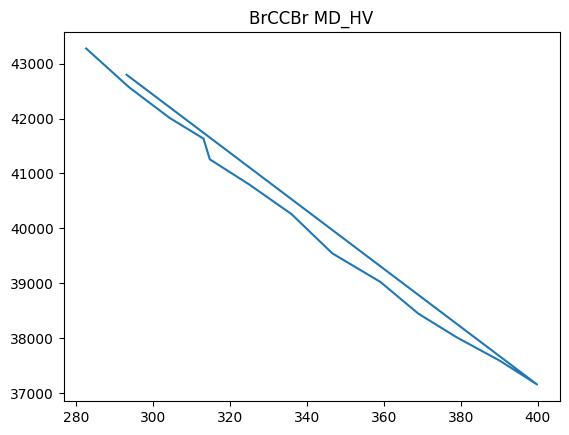

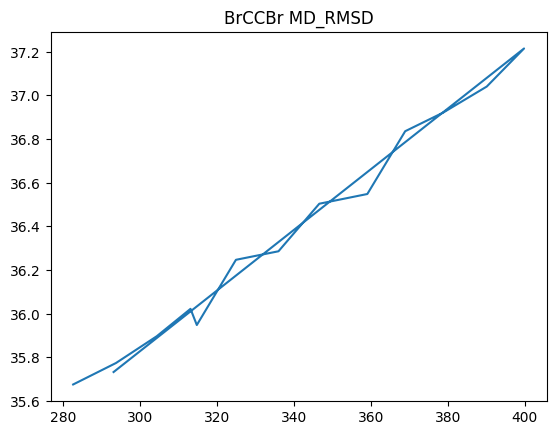

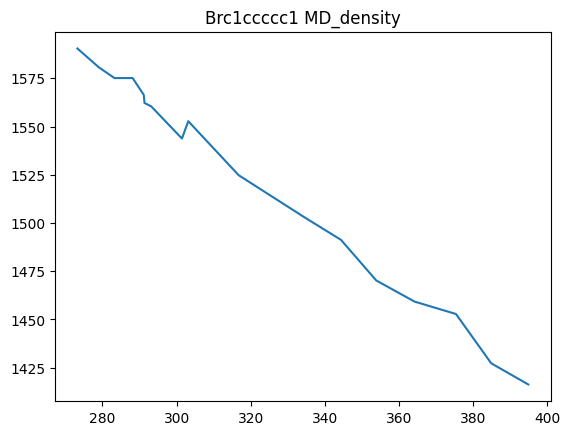

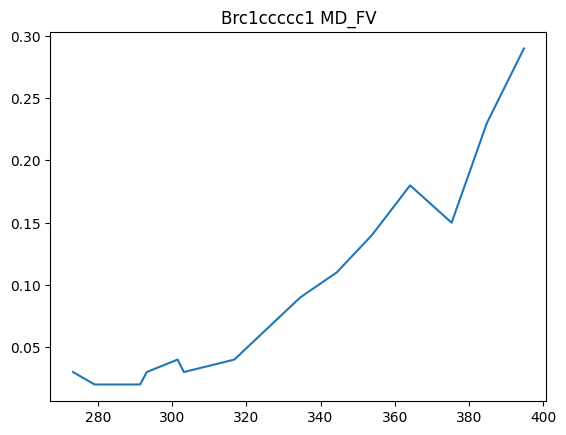

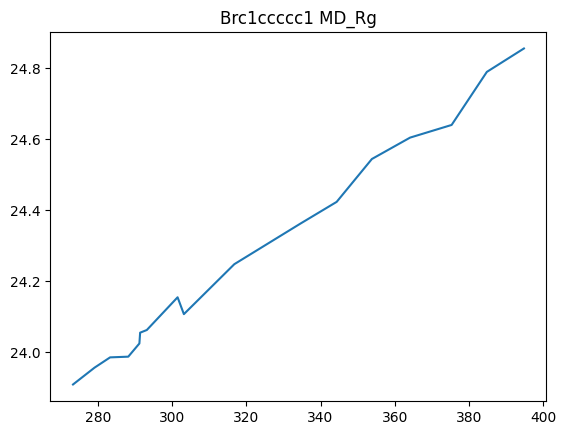

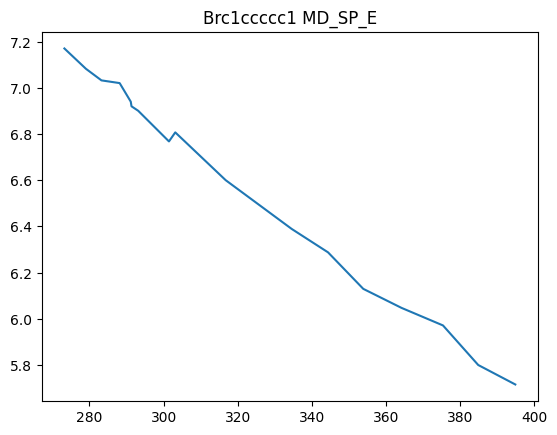

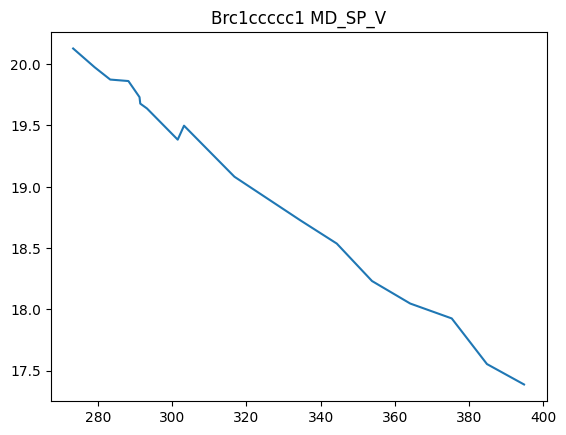

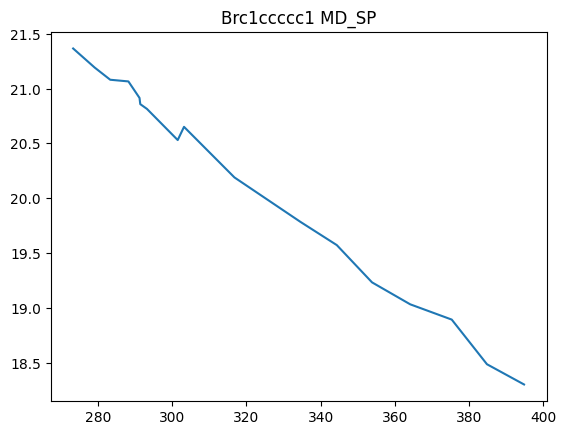

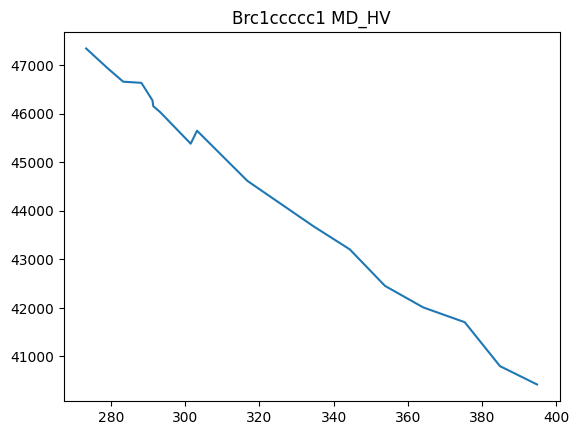

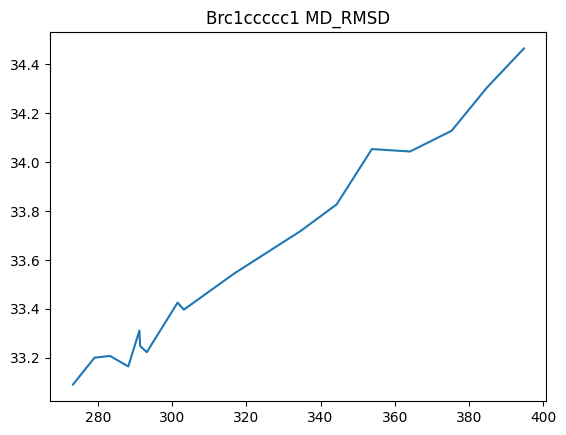

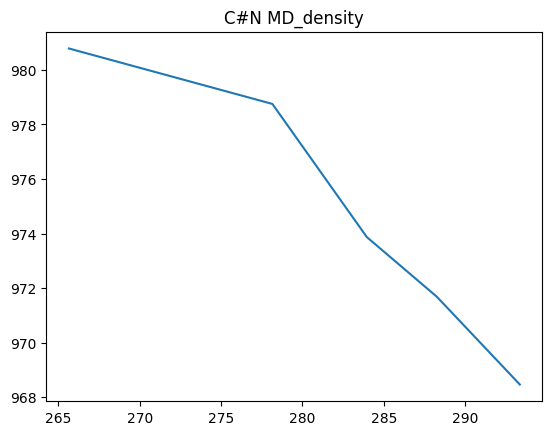

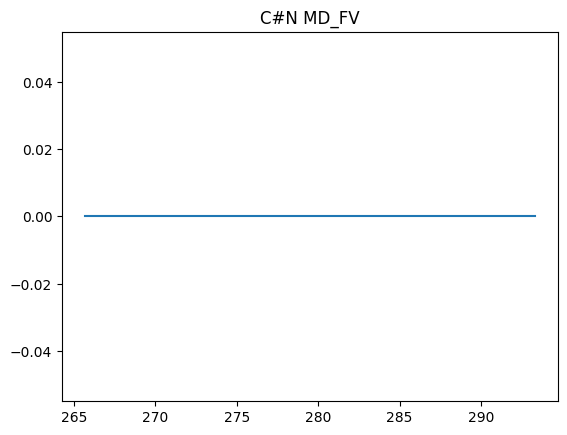

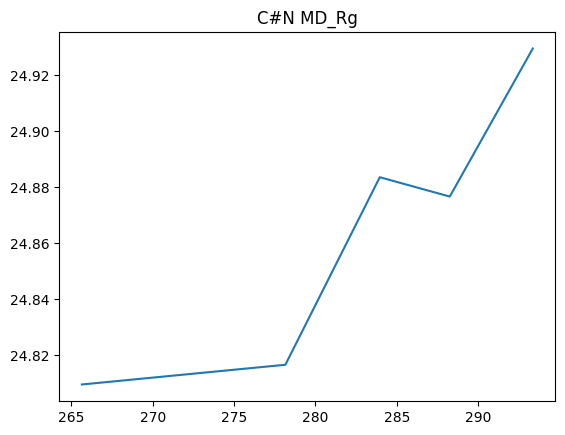

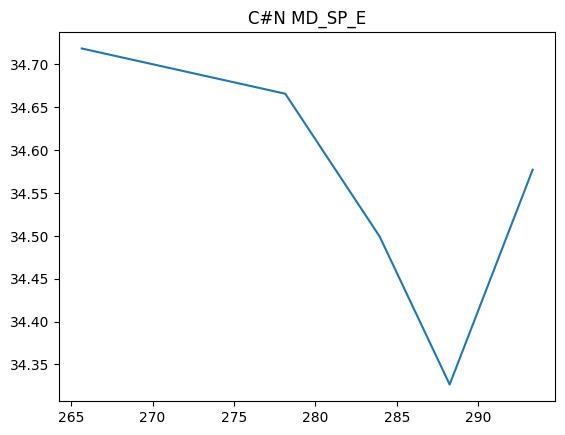

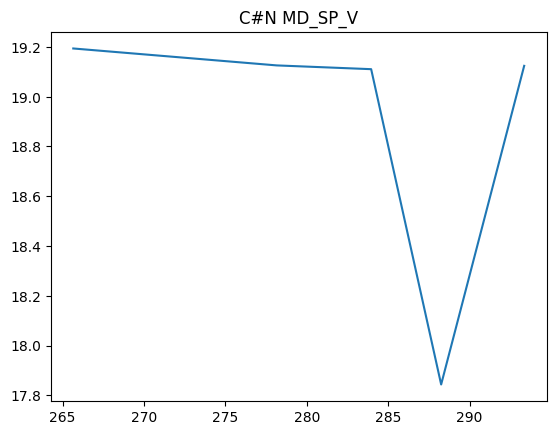

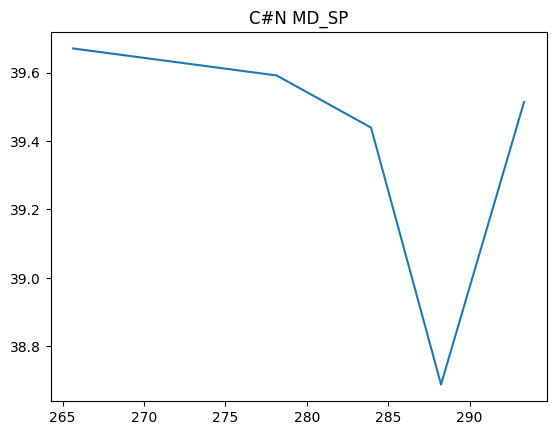

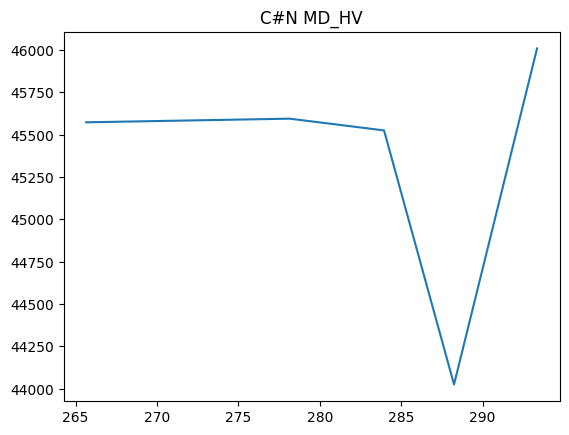

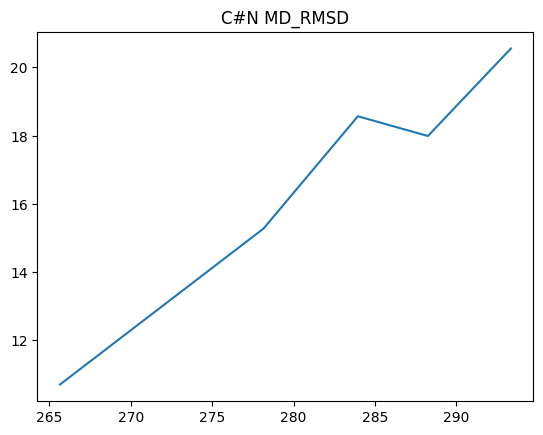

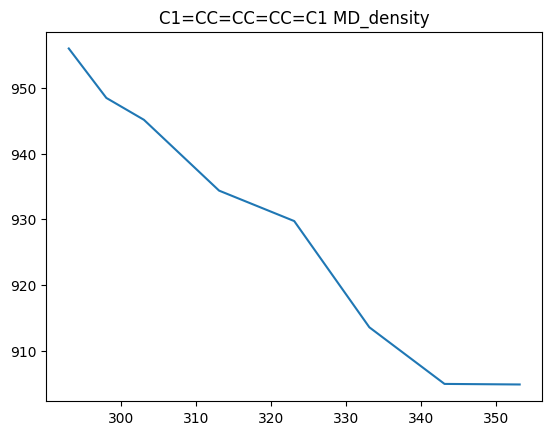

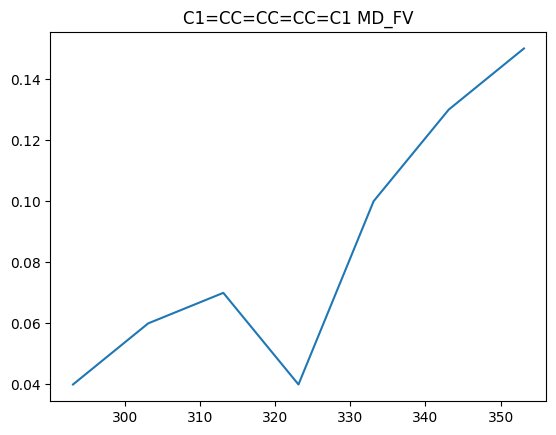

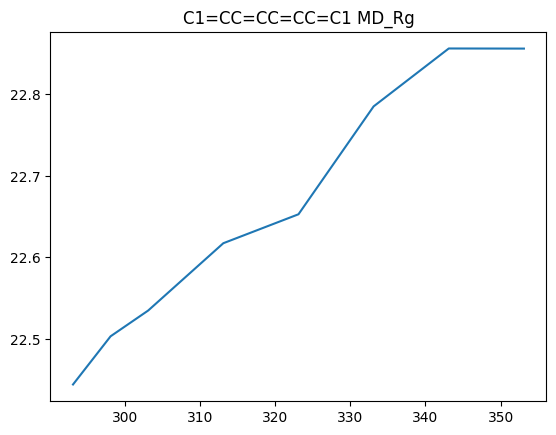

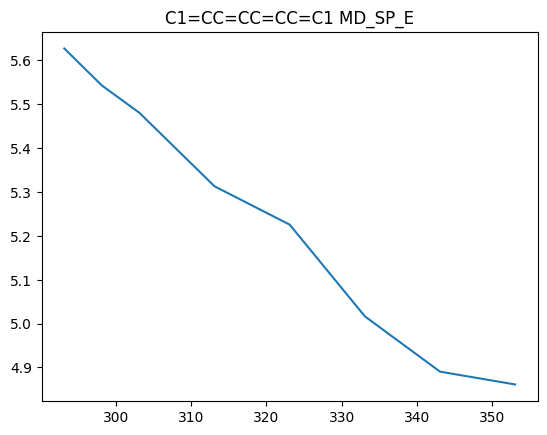

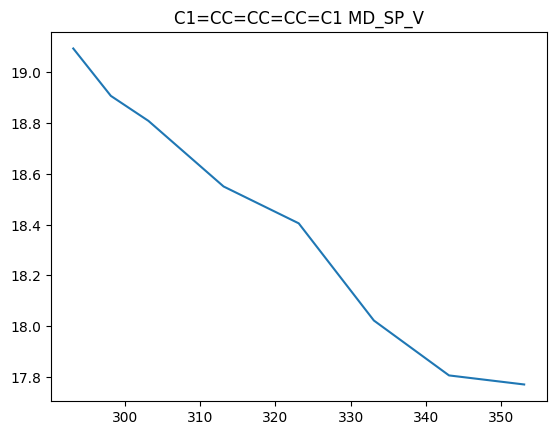

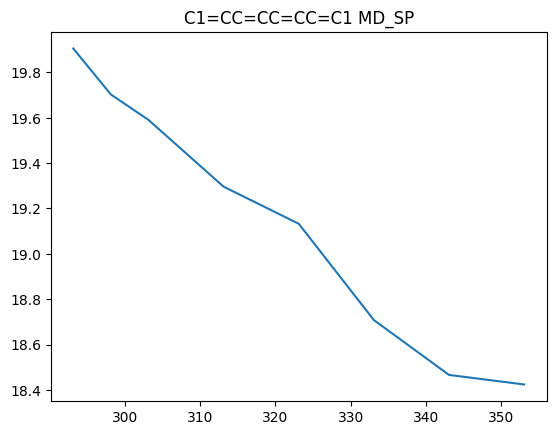

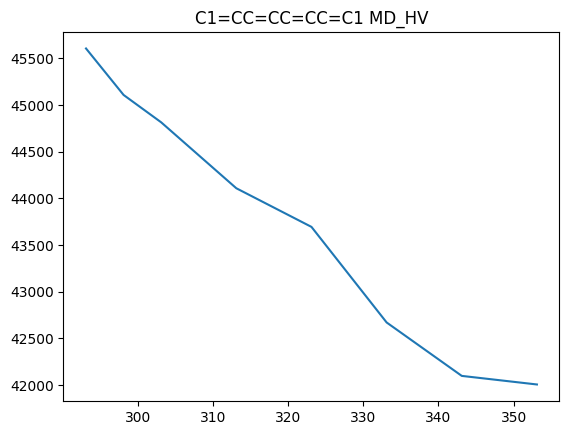

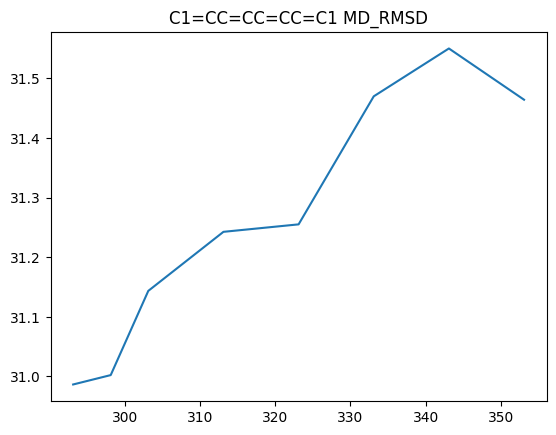

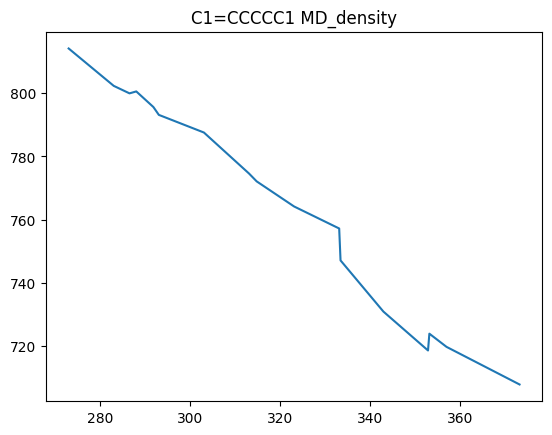

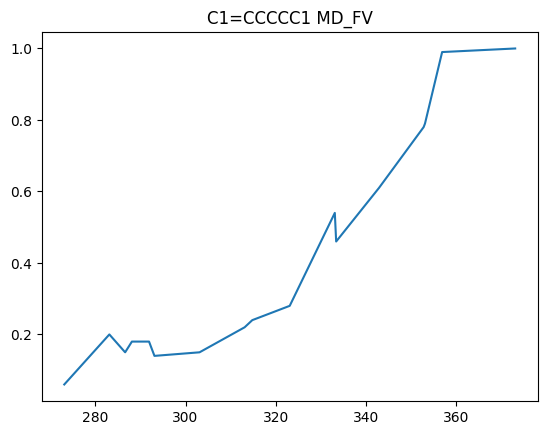

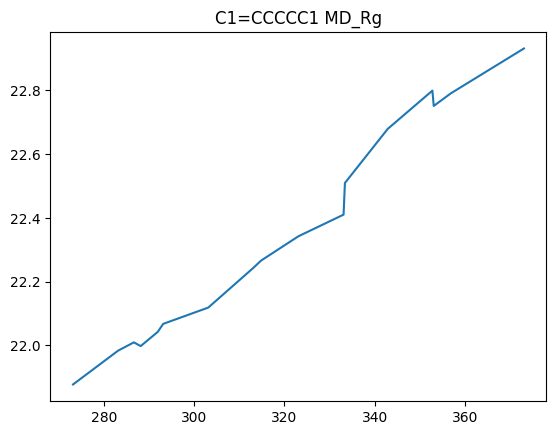

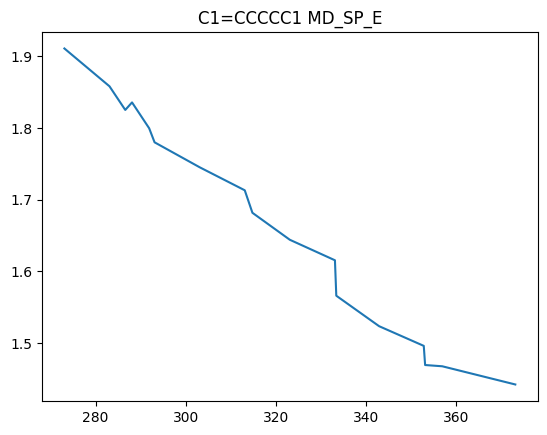

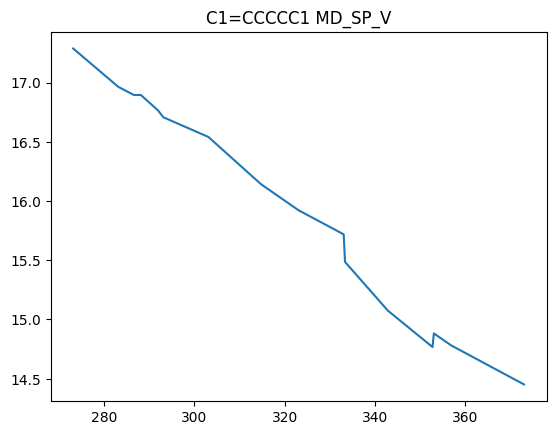

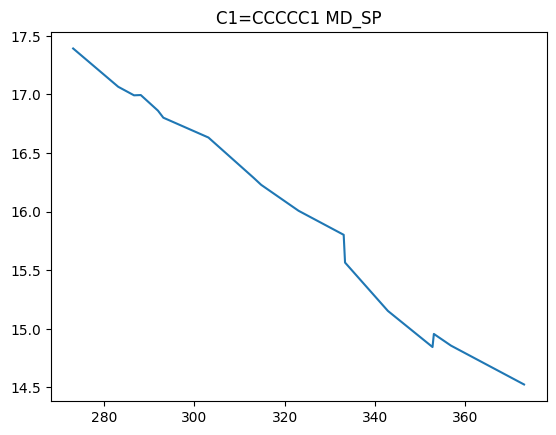

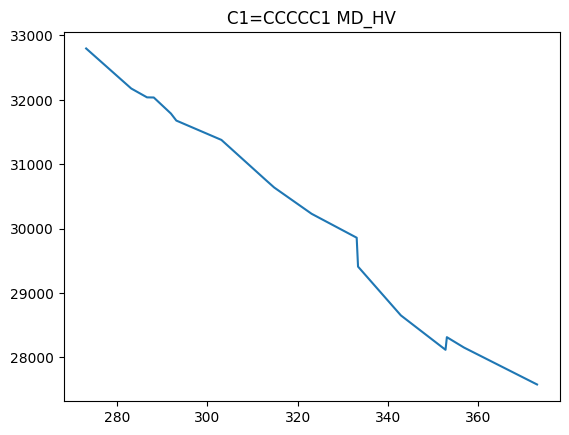

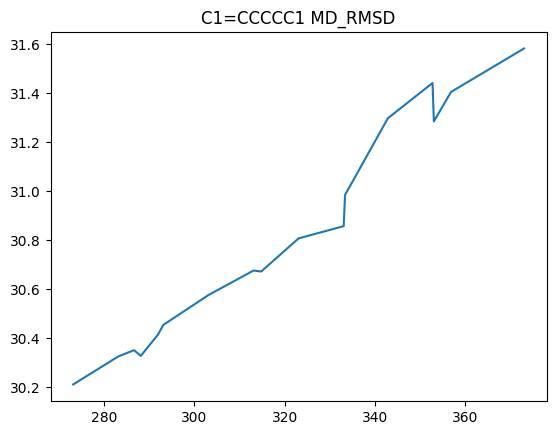

In [11]:
usmiles = np.unique(data["canonical_smiles"])

for i,smiles in enumerate(usmiles):
    #print(smiles)

    md = data[data["canonical_smiles"]==smiles]
    if md.shape[0] > 4:

        for kk in ['MD_density', 'MD_FV', 'MD_Rg', 'MD_SP_E', 'MD_SP_V', 'MD_SP', 'MD_HV', 'MD_RMSD']:
            plt.plot(md["temperature"], md[kk])
            plt.title( smiles+" "+ kk )
            plt.show()
            plt.close()

    if i > 20:
        break

[ 9.20628149 -0.39938937]
[ 8.90183767 -0.12300566]
[ 9.06234671 -0.290706  ]
[ 9.40168359 -0.26503864]
[ 9.54175186 -0.38184204]
[10.33803182 -0.57955848]
[10.09136038 -0.20898931]
[ 9.69207303 -0.21249972]
[ 9.6459371  -0.20969343]
[9.93214271 0.02034219]


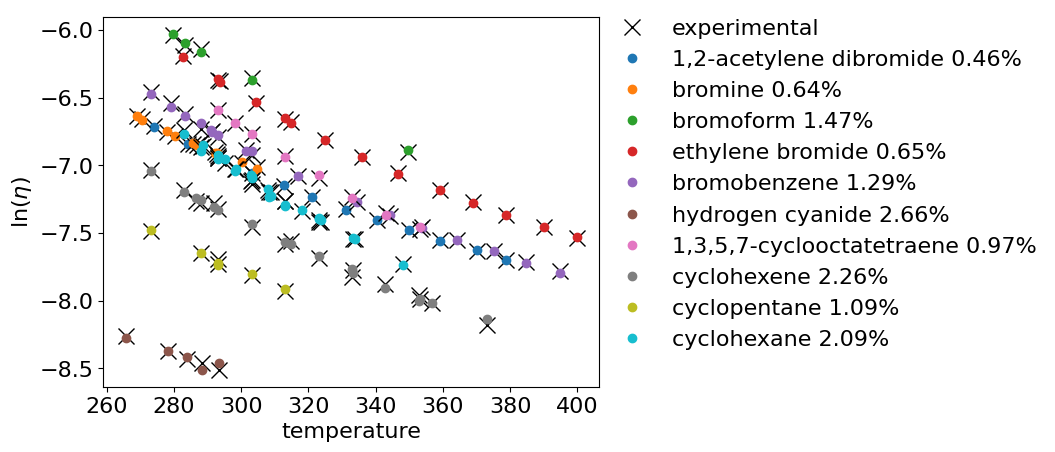

In [12]:
class Eyring():

    def __init__(self,data):
        self.data = data

        return

    def predict(self,p):
        a0,n = p
        n += 1
        y = self.data["dE_nRT"]*n - a0
        return y
    
    def error(self,p):           
        y = self.predict(p)
        yy = self.data["log_viscosity"]
        error = np.sum( ( (y-yy) / yy) **2 )
        return error

usmiles = np.unique(data["canonical_smiles"])

errors = 0
count = 0
plot_count=0

for i,smiles in enumerate(usmiles):
    #print(smiles)

    md = data[data["canonical_smiles"]==smiles]
    if md.shape[0] > 4:

        f = Eyring(md)

        #res = minimize(f.error, [0,4], bounds=[[-10,+10],[1,12]])
        #res = minimize(f.error, [0,4], bounds=[[-10,+10],[.1,12]])
        res = minimize(f.error, [0,4], bounds=[[-10,+20],[-12,12]])
        print(res.x)
        y = f.predict(res.x)
        
        log_vis = md["log_viscosity"]
        vis = md["viscosity"]
        T = md["temperature"]

        error = np.abs(( np.exp(y) - vis ) / vis)
        error = round(np.mean(error)*100,2)

        if i==0:
            plt.plot(T,log_vis,"kx",markersize=msize,label="experimental")
        else:
            plt.plot(T,log_vis,"kx",markersize=msize)
        plt.plot(T,y,".", label=md["iupac_name"].iloc[0]+" "+str(error)+"%",markersize=msize)

        #break
        errors += error
        count += 1
        if count > 9:
            break

#plt.xlim([0,30])
#plt.ylim([0,10])

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  
plt.legend(fontsize=fsize,frameon=False,bbox_to_anchor=(0.98, 1.05))
plt.xlabel(r"temperature",fontsize=fsize)  
plt.ylabel(r"ln($\eta$)",fontsize=fsize)  

plt.savefig(savepath+"eyring_example.png",bbox_inches='tight')
plt.savefig(savepath+"eyring_example.pdf",bbox_inches='tight')
plt.show()
plt.close()  


[ 9.20628149 -0.39938937]
[ 8.90183767 -0.12300566]
[ 9.06234671 -0.290706  ]
[ 9.40168359 -0.26503864]
[ 9.54175186 -0.38184204]
[10.33803182 -0.57955848]
[10.09136038 -0.20898931]
[ 9.69207303 -0.21249972]
[ 9.6459371  -0.20969343]
[9.93214271 0.02034219]


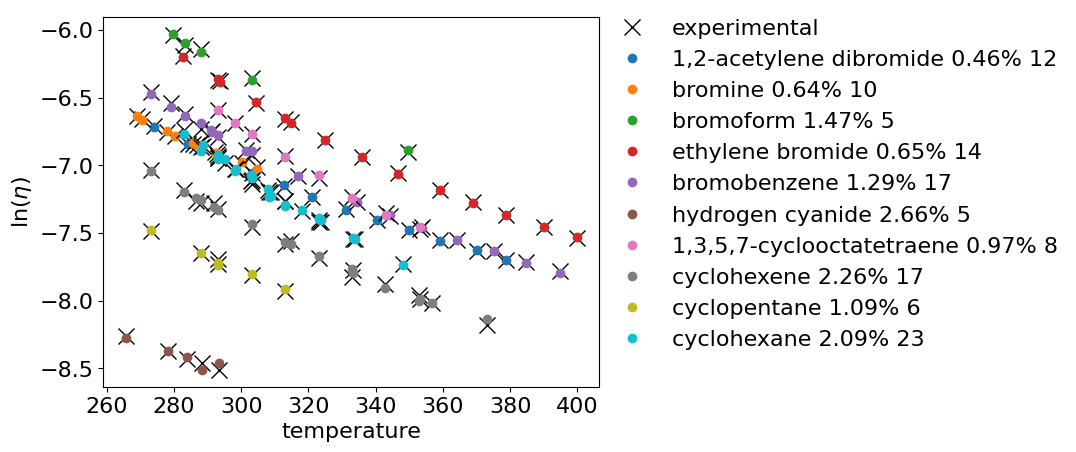

[10.18788777  0.0794766 ]
[ 9.733146   -0.21850132]
[ 9.95066046 -0.074878  ]
[ 9.60137647 -0.25702718]
[ 9.97853406 -0.39208023]
[10.01712203 -0.4603901 ]
[ 9.92871498 -0.37031023]
[ 9.41772184 -0.03413779]
[ 9.50254197 -0.39562398]
[ 9.73176585 -0.35575287]


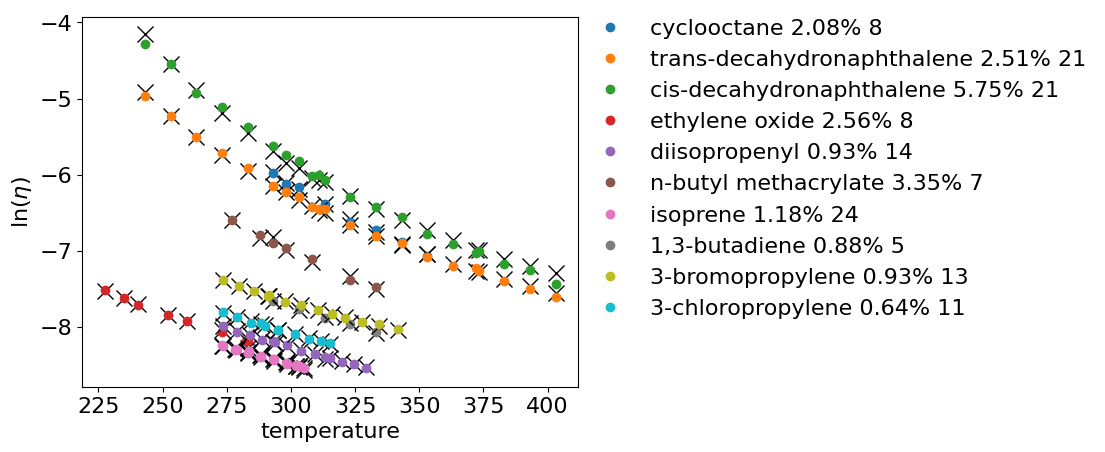

[ 9.4015079  -0.35548444]
[10.36249008 -0.14905507]
[ 9.78775655 -0.36853705]
[ 9.85833462 -0.41646116]
[11.41265532 -0.07709023]
[ 9.96531497 -0.37766152]
[ 9.8366503  -0.45789031]
[10.49342611 -0.26717258]
[ 9.93975602 -0.28085855]
[ 9.29631244 -0.45287811]


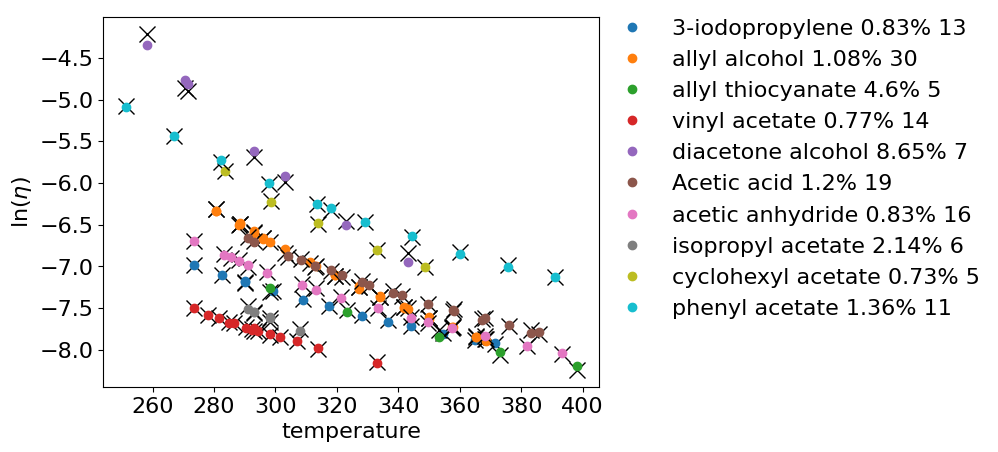

[ 9.44076064 -0.32127093]
[ 9.65813747 -0.24819654]
[12.20039365  0.46956641]
[ 9.87145415 -0.36694725]
[ 9.70190672 -0.31835834]
[ 9.84880805 -0.31439093]
[ 9.7645135 -0.4825083]
[10.2326147  -0.13636111]
[ 9.59662877 -0.35267464]
[10.84539002 -0.45792452]


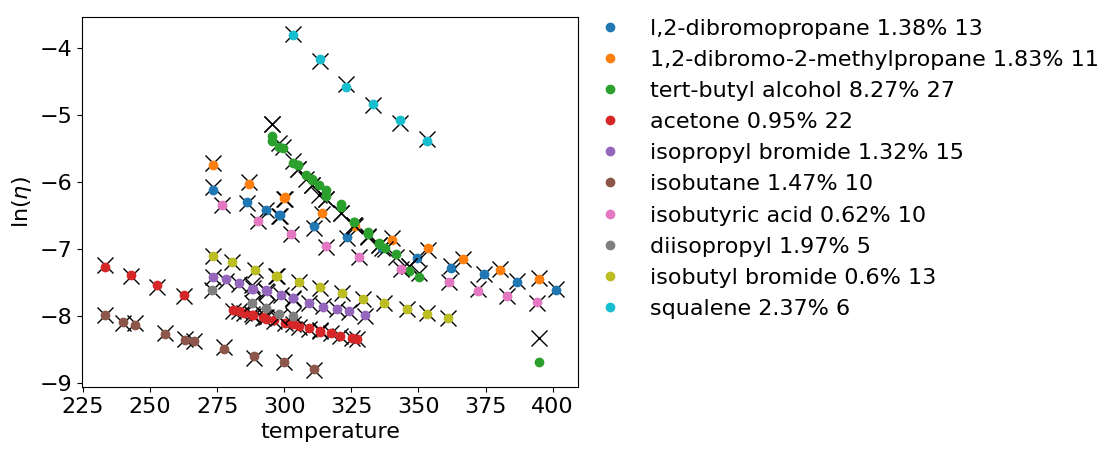

[11.20116252 -0.44062478]
[ 1.07283590e+01 -6.84343204e-03]
[ 9.70112395 -0.33686811]
[ 9.48691718 -0.36434698]
[10.95515703  0.12127299]
[ 9.75739416 -0.34380342]
[ 9.37391236 -0.37749544]
[11.29320705  0.19660141]
[14.12010417  0.57199195]
[ 1.06648340e+01 -8.67662852e-03]


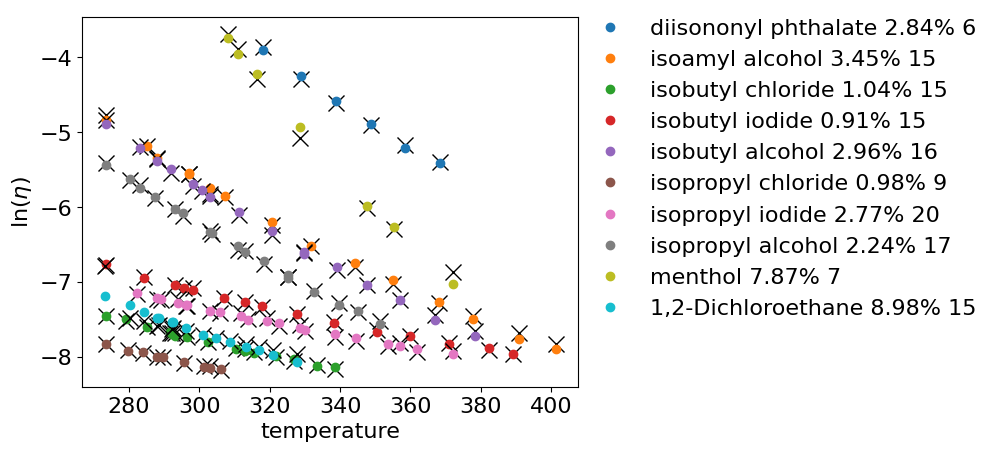

[ 9.62999744 -0.29093289]
[ 9.75677485 -0.23570818]
[ 9.66218974 -0.30826199]
[ 9.85012058 -0.41884593]
[ 9.70444173 -0.292402  ]
[10.12796211 -0.22154442]
[ 9.81118896 -0.43975975]
[ 9.84965395 -0.40936138]
[ 9.89266609 -0.48056519]
[ 9.75276976 -0.30942041]


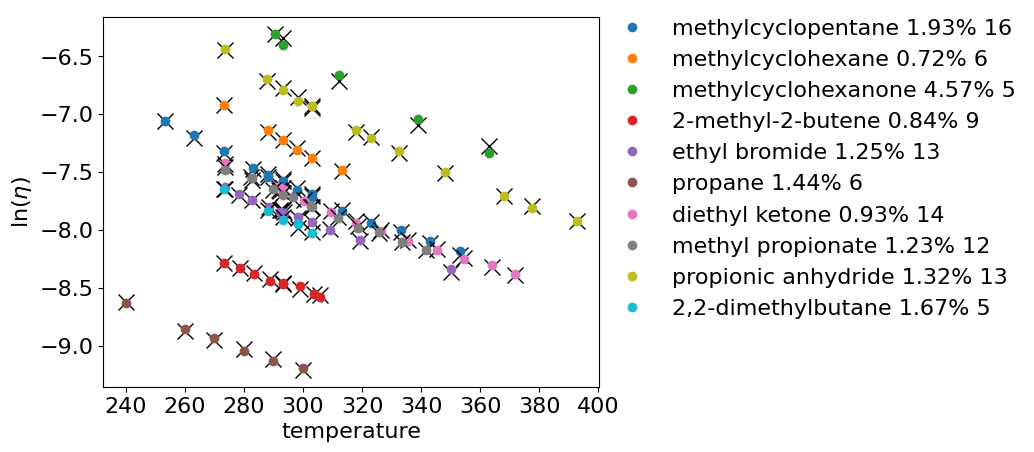

[11.57764905  0.26780331]
[ 9.81863152 -0.39286237]
[10.56960059 -0.18087213]
[11.39587984  0.21309394]
[ 9.52695065 -0.38024487]
[ 9.48830533 -0.37825736]
[ 9.85888867 -0.32895092]
[ 9.80443107 -0.45515865]
[ 9.86127239 -0.40778746]
[ 9.74924045 -0.4270931 ]


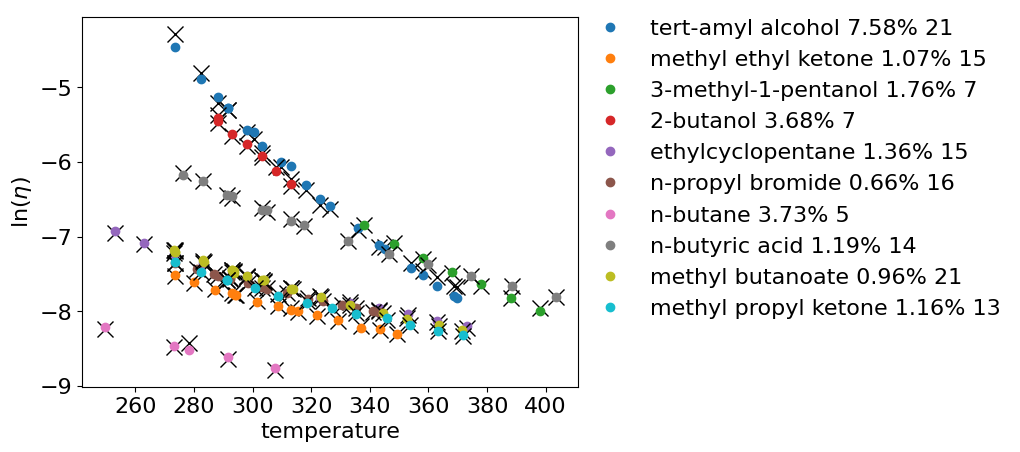

[ 9.86304995 -0.36722492]
[11.58869394  0.21271308]
[ 9.67576965 -0.43961231]
[ 9.92659    -0.42076163]
[ 9.74773921 -0.42719796]
[11.55898575  0.15940896]
[10.33423546 -0.51616011]
[11.37091749  0.08620678]
[ 9.61293182 -0.36259545]
[ 9.62431598 -0.45094967]


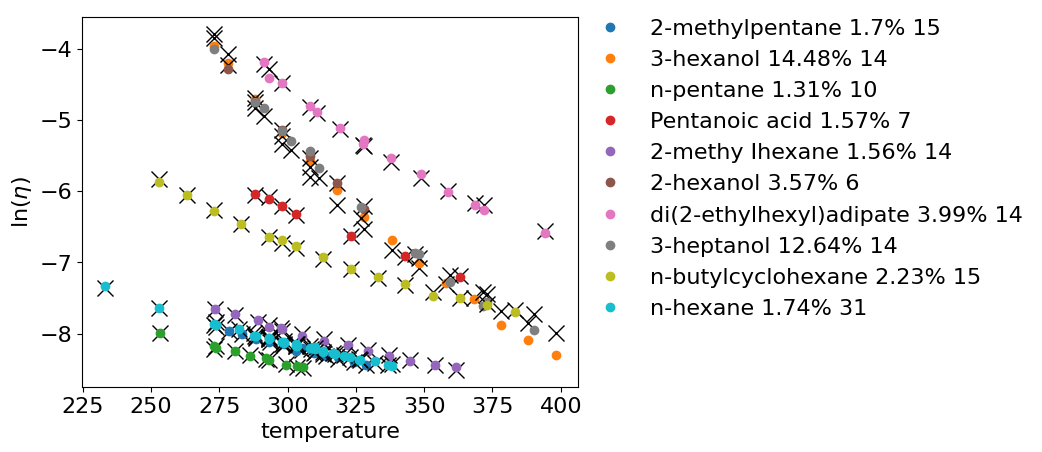

[ 9.94751601 -0.40344728]
[ 9.68631002 -0.43254521]
[ 9.87804539 -0.41239037]
[ 9.74687881 -0.41962198]
[ 9.77237662 -0.42318246]
[ 9.73852956 -0.44283411]
[10.18384334 -0.38804408]
[ 9.76706235 -0.53478355]
[10.85211969 -0.38293926]
[ 9.67286629 -0.46434325]


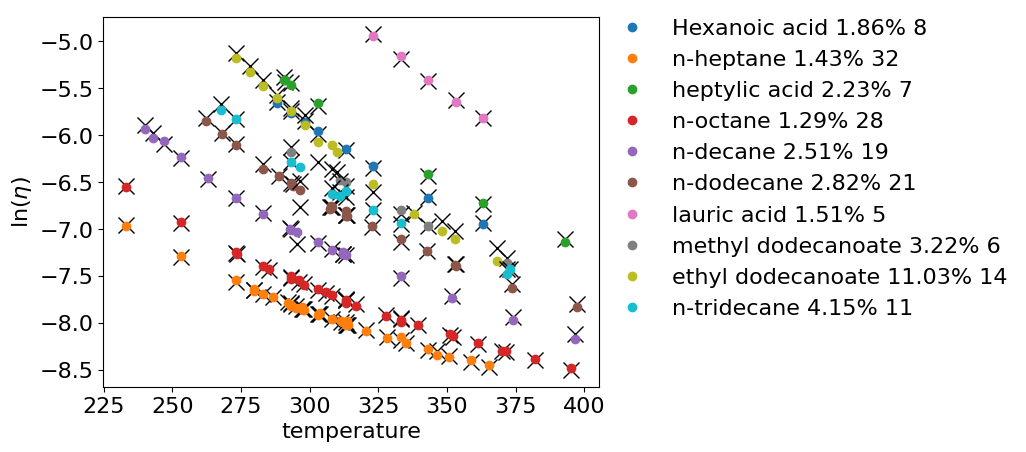

[ 9.65136533 -0.47509879]
[ 9.76430182 -0.52077807]
[ 9.39824825 -0.68805184]
[ 9.58587084 -0.49694692]
[ 9.62641624 -0.4948136 ]
[ 9.63418317 -0.50423281]
[ 9.72075555 -0.58913612]
[ 9.55671651 -0.54243285]
[ 9.31977125 -0.5941237 ]
[ 9.7820231  -0.46391098]


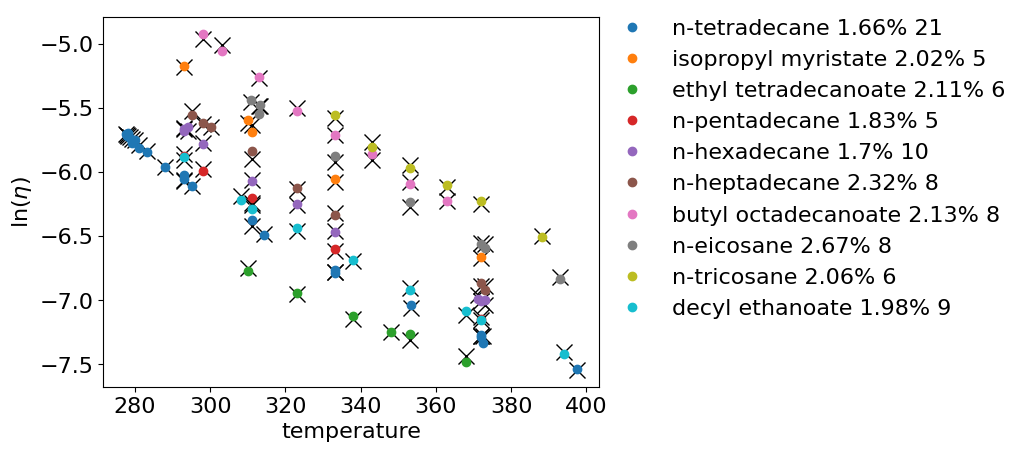

[10.66983718 -0.33078985]
[10.10985839 -0.38892395]
[ 9.55363153 -0.6079894 ]
[ 9.75731034 -0.45397998]
[ 9.8941141  -0.41764624]
[ 9.77201104 -0.43776491]
[11.903219   -0.08141169]
[1.08228714e+01 1.00325464e-02]
[ 9.5382576  -0.51320215]
[10.06154281 -0.36041797]


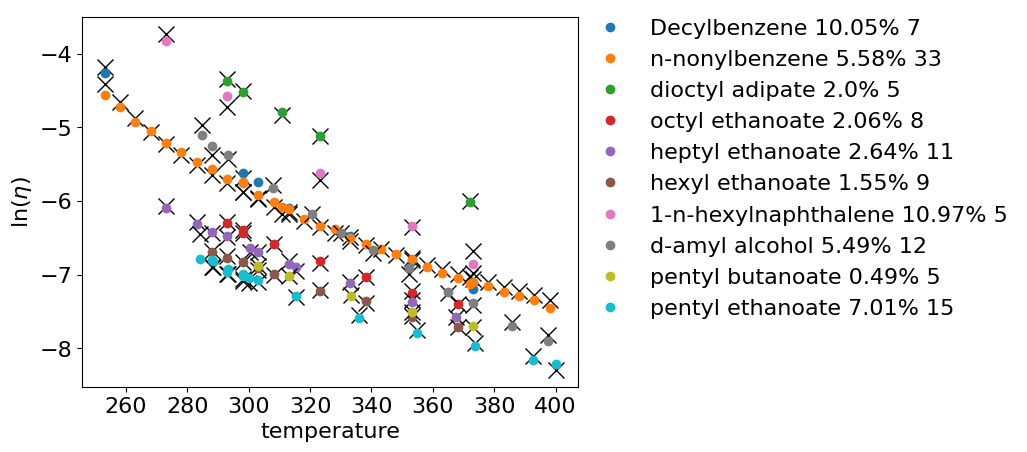

[10.65088919 -0.01574617]
[ 9.67146049 -0.47940887]
[10.17214591 -0.51948426]
[11.2617982 -0.3127032]
[ 9.81347207 -0.41762942]
[ 9.65984565 -0.40181758]
[ 9.76217449 -0.31572833]
[1.05941292e+01 9.39659359e-03]
[ 9.80855694 -0.42302562]
[ 9.83341678 -0.43799412]


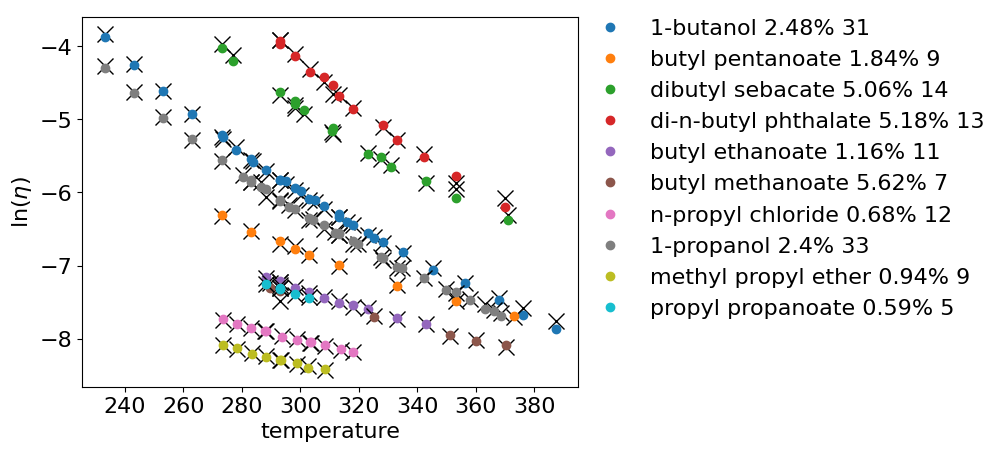

[ 9.81499327 -0.43088021]
[ 9.86395135 -0.39688746]
[ 9.75280289 -0.36680156]
[ 9.83842343 -0.40793587]
[ 9.74251907 -0.4246973 ]
[10.41337272 -0.22546542]
[10.19530568 -0.23824635]
[10.14067433 -0.16201287]
[10.07518356 -0.4332711 ]
[ 9.81811998 -0.44754311]


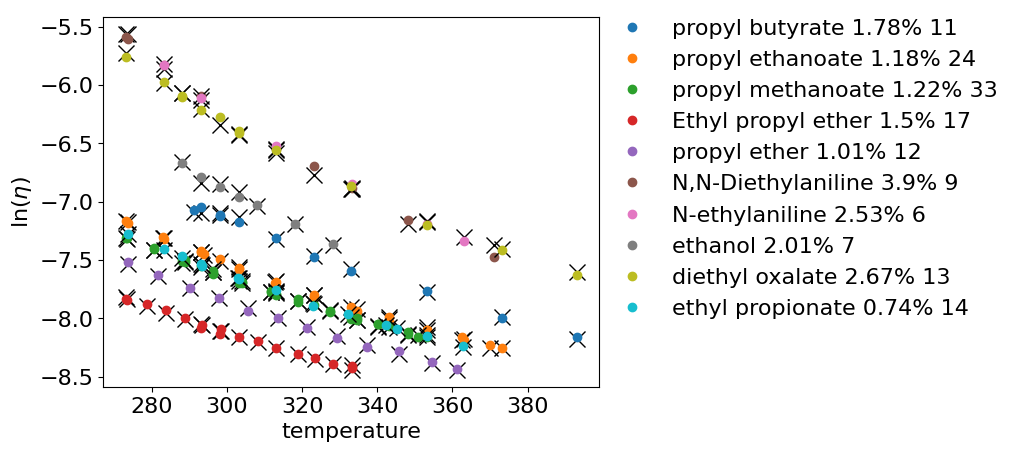

[10.30302111 -0.40904017]
[ 9.94173889 -0.42992983]
[ 9.86165381 -0.43990196]
[10.01522461 -0.39293465]
[11.55886538 -0.22523787]
[ 9.8457938  -0.41306331]
[11.02087286 -0.12864157]
[ 9.69136889 -0.38240331]
[ 9.82255189 -0.42247896]
[ 9.89002081 -0.37445108]


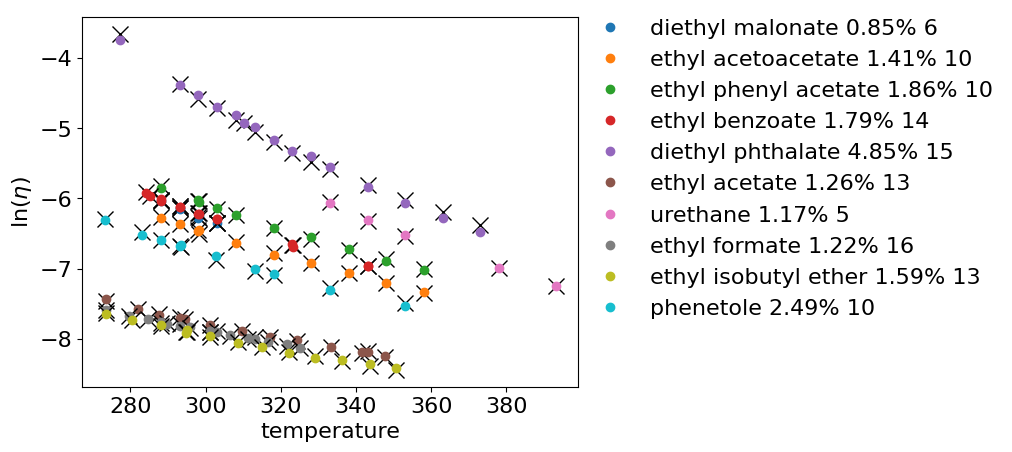

[ 9.71086933 -0.44330493]
[ 9.67631142 -0.40995556]
[ 9.30392615 -0.32888312]
[ 9.55219014 -0.39570095]
[10.72369492 -0.19486782]
[10.32235076 -0.16065993]
[10.10224626 -0.23173381]
[ 9.77453521 -0.45588282]
[10.74023998 -0.20799623]
[10.00399483 -0.38806458]


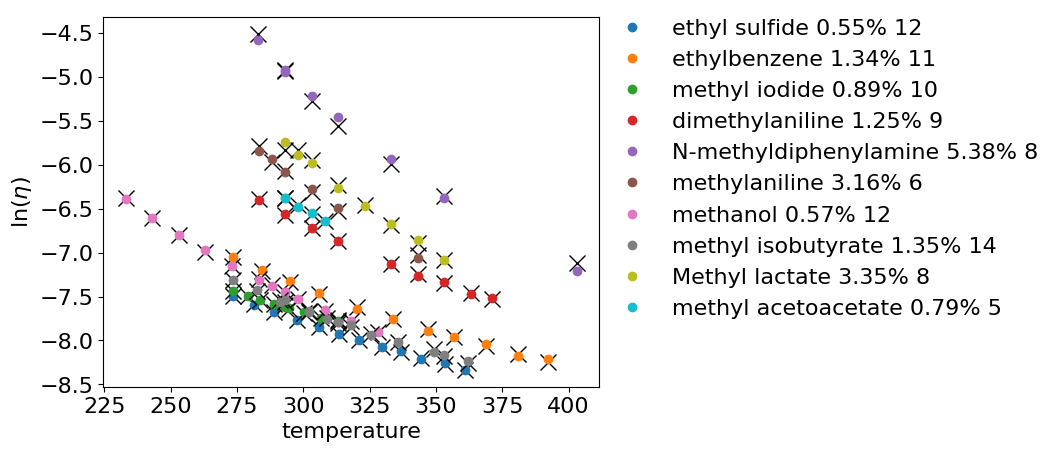

[10.43928644 -0.29056609]
[12.19060341 -0.06407343]
[ 9.9576988  -0.37673613]
[ 9.85118479 -0.37737009]
[ 9.67600743 -0.33323666]
[ 9.83304013 -0.42128743]
[10.13750619 -0.44587269]
[10.34208459 -0.13421101]
[ 9.67653475 -0.42527687]
[ 1.15311311e+01 -3.86997557e-03]


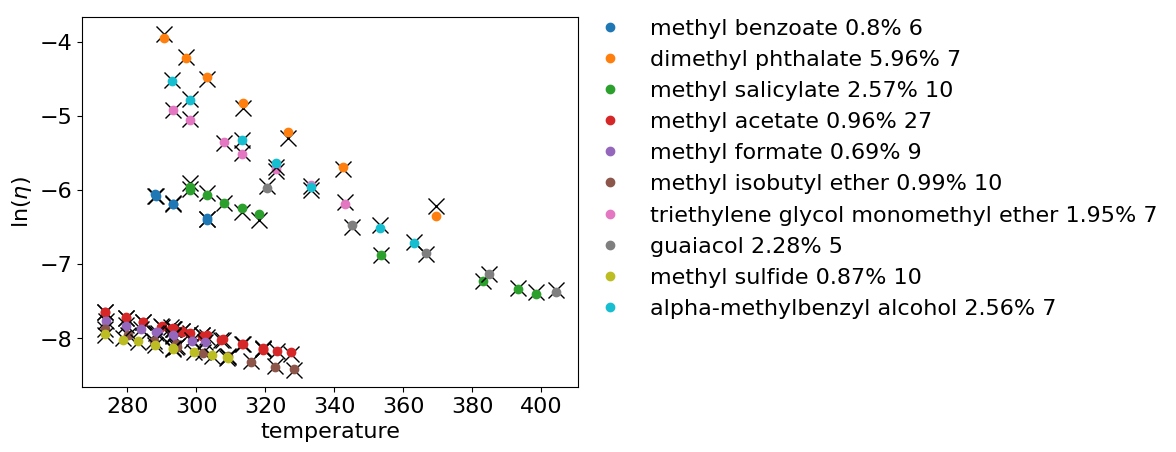

[ 9.87872104 -0.16426159]
[ 9.54149591 -0.41477071]
[ 9.83149389 -0.25706863]
[ 9.61348428 -0.30375821]
[ 9.63925883 -0.35249873]
[ 9.68577776 -0.31809253]
[ 9.75308002 -0.40830237]
[ 9.97572639 -0.2014589 ]
[11.99330703  0.1270599 ]
[ 9.6676438  -0.44177108]


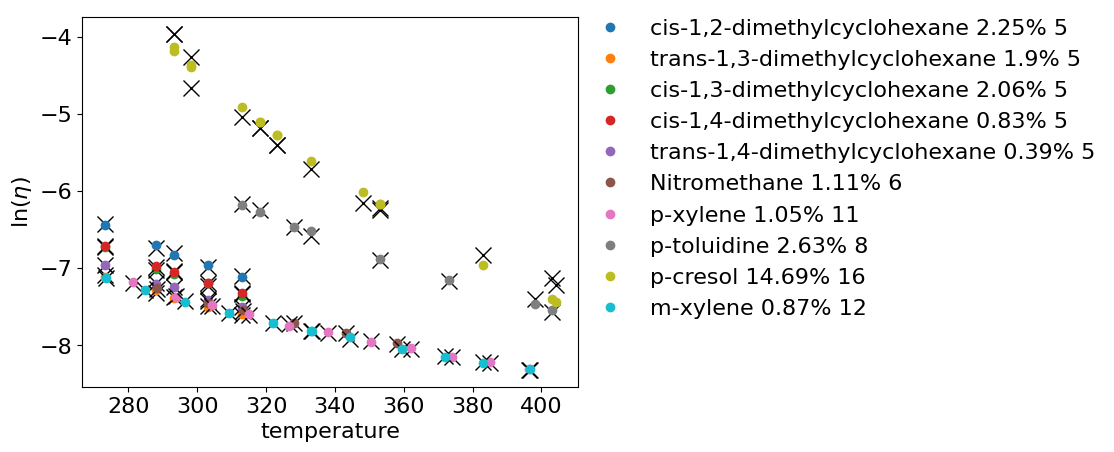

[10.34202357 -0.11982271]
[12.16058189  0.15434277]
[ 9.741657   -0.36125314]
[ 9.75077642 -0.35576661]
[10.92190099  0.12296726]
[11.51498801  0.03967843]
[ 9.82826671 -0.08850692]
[ 9.28522558 -0.38075875]
[ 9.60277871 -0.3190658 ]
[ 9.64538002 -0.36184354]


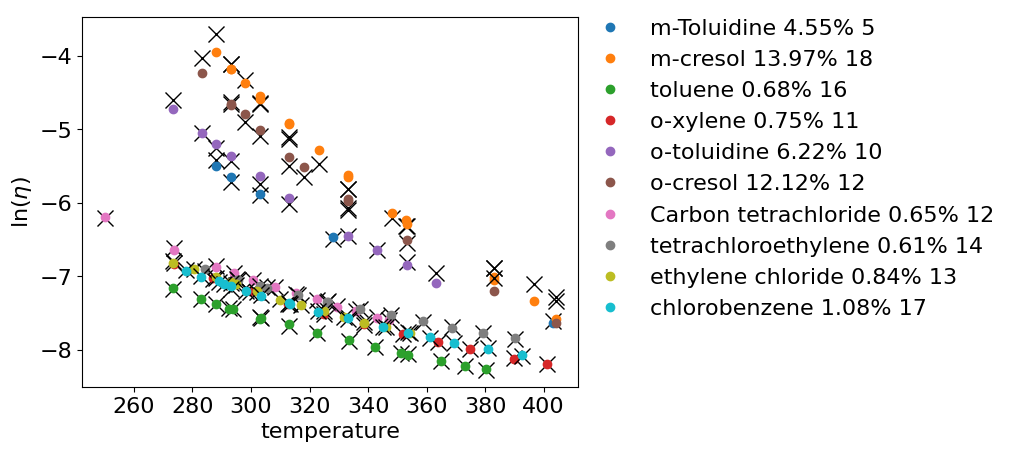

[ 9.75658601 -0.30172319]
[ 9.52997575 -0.35534599]
[10.62908957  0.05460578]
[11.08812466 -0.27964781]
[10.00440448 -0.11512965]
[ 9.80755875 -0.37871088]
[10.34349721 -0.09451767]
[14.75070238  0.30701449]
[ 9.79715148 -0.49855772]
[10.22549798 -0.25557939]


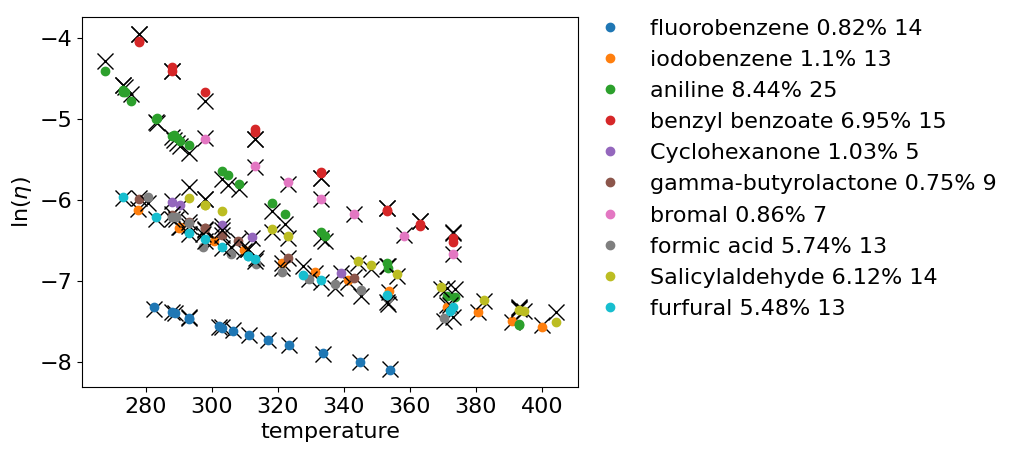

[ 9.4818985  -0.25276955]
[ 9.83847857 -0.41046432]
[ 9.80004907 -0.38144677]
[14.35078891  0.73253583]
[10.7089883   0.12152816]
[11.41269368  0.48443341]
[10.75312075 -0.18544666]
[10.24546192 -0.44112174]
[10.35115561 -0.20465589]
[10.35008761 -0.17034503]


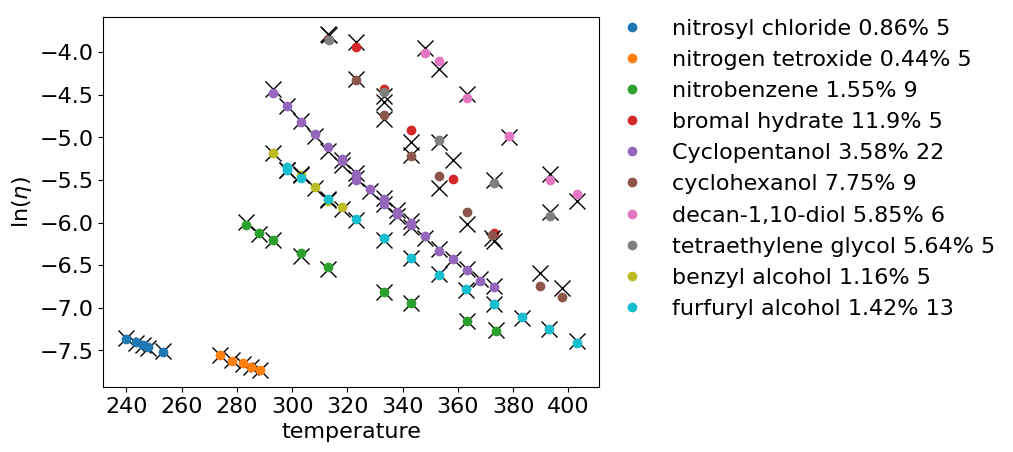

[12.21421374  0.18371774]
[11.0134441   0.09349172]
[ 9.42696119 -0.47962274]
[ 9.74030022 -0.28595829]
[ 9.97386279 -0.26028905]
[ 9.56134631 -0.38109936]
[ 9.6266805  -0.27693568]


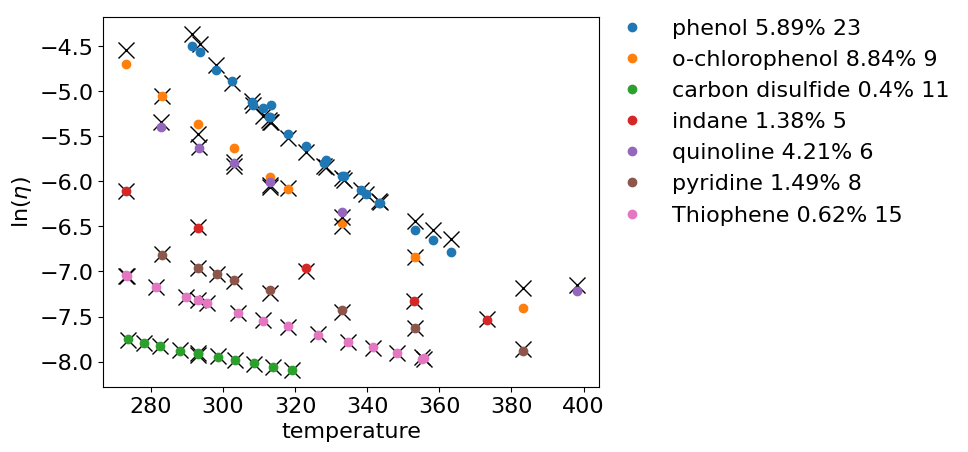

In [14]:
usmiles = np.unique(data["canonical_smiles"])

errors = 0
count = 0
plot_count=0

for i,smiles in enumerate(usmiles):
    #print(smiles)

    md = data[data["canonical_smiles"]==smiles]
    if md.shape[0] > 4:

        f = Eyring(md)

        #res = minimize(f.error, [0,4], bounds=[[-10,+10],[1,12]])
        #res = minimize(f.error, [0,4], bounds=[[-10,+10],[.1,12]])
        res = minimize(f.error, [0,4], bounds=[[-10,+20],[-12,12]])
        print(res.x)
        y = f.predict(res.x)
        
        log_vis = md["log_viscosity"]
        vis = md["viscosity"]
        T = md["temperature"]

        error = np.abs(( np.exp(y) - vis ) / vis)
        error = round(np.mean(error)*100,2)

        if i==0:
            plt.plot(T,log_vis,"kx",markersize=msize,label="experimental")
        else:
            plt.plot(T,log_vis,"kx",markersize=msize)
        plt.plot(T,y,".", label=md["iupac_name"].iloc[0]+" "+str(error)+"% "+str(md.shape[0]),markersize=msize)

        #break
        errors += error
        count += 1
        if count > 9:
            plt.xticks(fontsize=fsize)  
            plt.yticks(fontsize=fsize)  
            plt.legend(fontsize=fsize,frameon=False,bbox_to_anchor=(0.98, 1.05))
            plt.xlabel(r"temperature",fontsize=fsize)  
            plt.ylabel(r"ln($\eta$)",fontsize=fsize)  
            
            #plt.savefig(savepath+"eyring_example.png",bbox_inches='tight')
            #plt.savefig(savepath+"eyring_example.pdf",bbox_inches='tight')
            plt.show()
            plt.close()
            count=0

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  
plt.legend(fontsize=fsize,frameon=False,bbox_to_anchor=(0.98, 1.05))
plt.xlabel(r"temperature",fontsize=fsize)  
plt.ylabel(r"ln($\eta$)",fontsize=fsize)  

#plt.savefig(savepath+"eyring_example.png",bbox_inches='tight')
#plt.savefig(savepath+"eyring_example.pdf",bbox_inches='tight')
plt.show()
plt.close()  

In [35]:
class Eyring():

    def __init__(self,data):
        self.data = data

        return

    def predict(self,p):
        a0,n = p
        #n += 1
        y = self.data["dE_RT"]/n - a0
        return y
    
    def error(self,p):           
        y = self.predict(p)
        yy = self.data["log_viscosity"]
        error = np.sum( ( (y-yy) / yy) **2 )
        return error

usmiles = np.unique(data["canonical_smiles"])

errors = 0
count = 0
plot_count=0
fit_paras = []

ns = np.zeros(len(data["canonical_smiles"]))
a0s = np.zeros(len(data["canonical_smiles"]))

for i,smiles in enumerate(usmiles):
    #print(smiles)

    pp = data["canonical_smiles"]==smiles
    md = data[pp]
    if md.shape[0] > 4:

        f = Eyring(md)

        #res = minimize(f.error, [0,4], bounds=[[-10,+10],[1,12]])
        #res = minimize(f.error, [0,4], bounds=[[-10,+10],[.1,12]])
        res = minimize(f.error, [0,4], bounds=[[-10,+20],[-12,22]])
        #print(res.x)
        y = f.predict(res.x)
        fit_paras.append(res.x)

        a0s[pp] = res.x[0]
        ns[pp] = res.x[1]
        
        log_vis = md["log_viscosity"]
        vis = md["viscosity"]
        T = md["temperature"]

        error = np.abs(( np.exp(y) - vis ) / vis)
        error = round(np.mean(error)*100,2)

"""
        plt.plot(T,log_vis,"kx")
        plt.plot(T,y,".", label=md["iupac_name"].iloc[0]+" "+str(error)+"%")

        #break
        errors += error
        count += 1
        if count > 12:
            #break
            plt.xlabel("temperature / K")
            plt.ylabel("log vis")
            plt.legend()
            #plt.savefig("n_a0_fit_"+str(int(plot_count))+".png")
            #plt.savefig("n_a0_fit_"+str(int(plot_count))+".pdf")
            plt.show()
            plt.close()        
            count = 0
            plot_count += 1

plt.xlabel("temperature / K")
plt.ylabel("log vis")
plt.legend()

plt.show()
plt.close()
"""

fit_paras = np.array(fit_paras).T

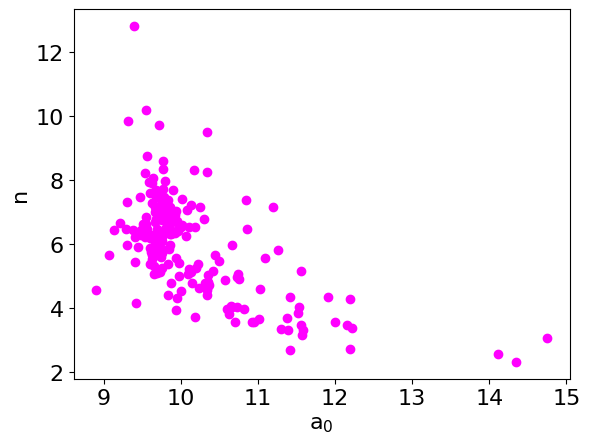

In [36]:
a0 = fit_paras[0] 
n0 = fit_paras[1]

plt.plot( a0,n0, ".",markersize=msize,color="magenta")

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  
#plt.legend(fontsize=fsize,frameon=False)
plt.xlabel(r"a$_0$",fontsize=fsize)  
plt.ylabel(r"n",fontsize=fsize)  

plt.savefig(savepath+"n0_a0.png",bbox_inches='tight')
plt.savefig(savepath+"n0_a0.pdf",bbox_inches='tight')
plt.show()
plt.close()    

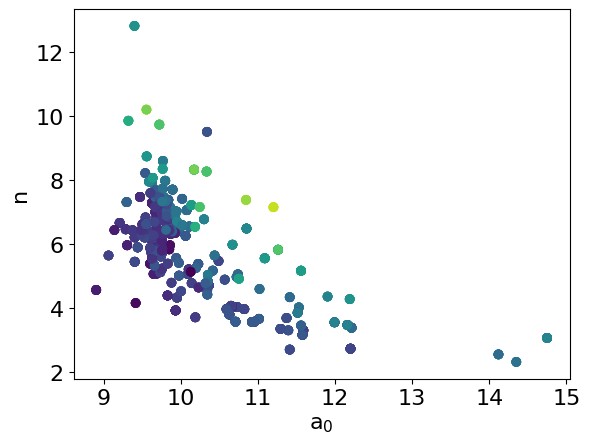

In [37]:
p = ns != 0
plt.scatter(a0s[p], ns[p], c=data["dE"][p])

#plt.xlim([0,15])
#plt.ylim([0,10])

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  
#plt.legend(fontsize=fsize,frameon=False)
plt.xlabel(r"a$_0$",fontsize=fsize)  
plt.ylabel(r"n",fontsize=fsize)  

#plt.savefig(savepath+"log_value_dE_nRT.png",bbox_inches='tight')
#plt.savefig(savepath+"log_value_dE_nRT.pdf",bbox_inches='tight')
plt.show()
plt.close()  

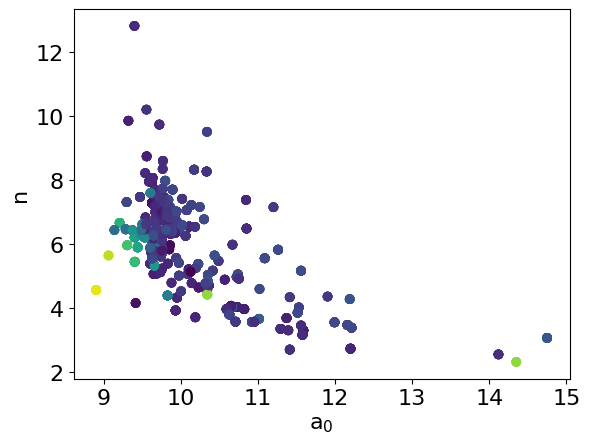

In [38]:
p = ns != 0
plt.scatter(a0s[p], ns[p], c=data["MD_density"][p])

#plt.xlim([0,15])
#plt.ylim([0,10])

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  
#plt.legend(fontsize=fsize,frameon=False)
plt.xlabel(r"a$_0$",fontsize=fsize)  
plt.ylabel(r"n",fontsize=fsize)  

#plt.savefig(savepath+"log_value_dE_nRT.png",bbox_inches='tight')
#plt.savefig(savepath+"log_value_dE_nRT.pdf",bbox_inches='tight')
plt.show()
plt.close()  

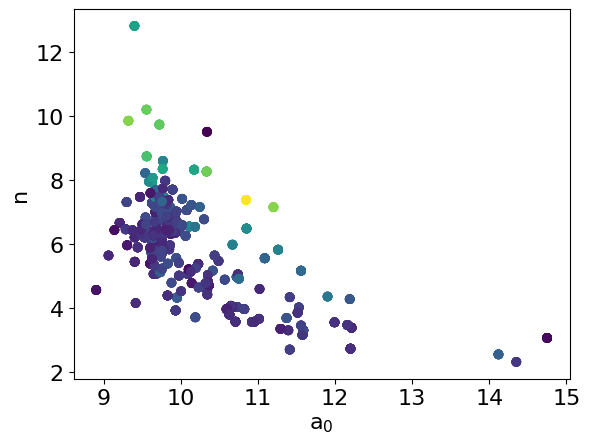

In [39]:
p = ns != 0
plt.scatter(a0s[p], ns[p], c=data["volume"][p])

#plt.xlim([0,15])
#plt.ylim([0,10])

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  
#plt.legend(fontsize=fsize,frameon=False)
plt.xlabel(r"a$_0$",fontsize=fsize)  
plt.ylabel(r"n",fontsize=fsize)  

#plt.savefig(savepath+"log_value_dE_nRT.png",bbox_inches='tight')
#plt.savefig(savepath+"log_value_dE_nRT.pdf",bbox_inches='tight')
plt.show()
plt.close()  

/home/derwer/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


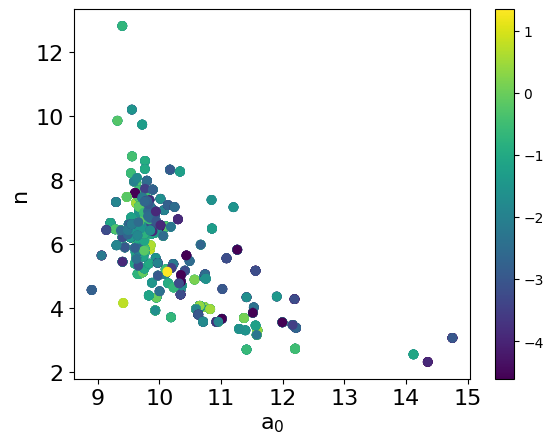

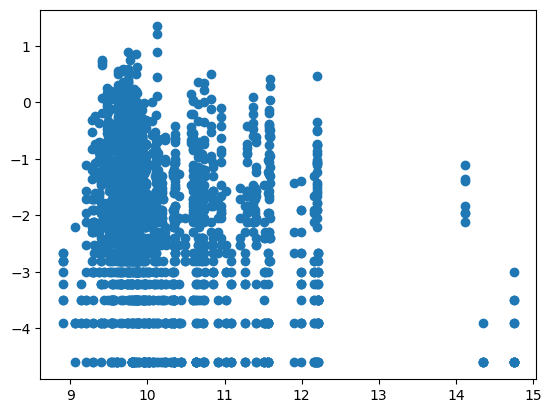

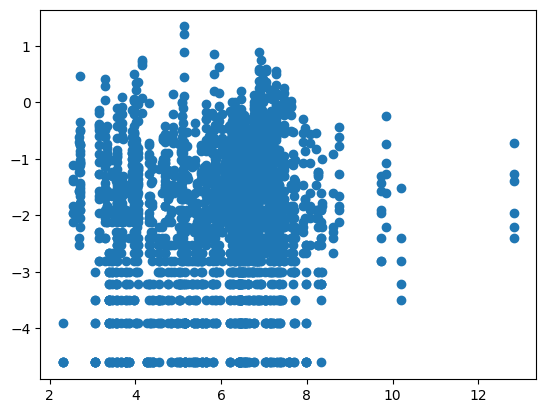

In [40]:
p = ns != 0
xx = "MD_HV"
xx = "dE_RT"
xx = "MD_density"
xx = "MD_RMSD"
xx = "MD_Rg"
xx = "MD_FV"
xxx = np.log(data[xx])
#xxx = data[xx]
cbar = plt.scatter(a0s[p], ns[p], c=xxx[p])
plt.colorbar(cbar)

#plt.xlim([0,15])
#plt.ylim([0,10])

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  
#plt.legend(fontsize=fsize,frameon=False)
plt.xlabel(r"a$_0$",fontsize=fsize)  
plt.ylabel(r"n",fontsize=fsize)  

#plt.savefig(savepath+"log_value_dE_nRT.png",bbox_inches='tight')
#plt.savefig(savepath+"log_value_dE_nRT.pdf",bbox_inches='tight')
plt.show()
plt.close()  

"""
###################################################


plt.scatter(a0s[p], xxx[p], c=ns[p])

#plt.xlim([0,15])
#plt.ylim([0,10])

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  
#plt.legend(fontsize=fsize,frameon=False)
plt.xlabel(r"a$_0$",fontsize=fsize)  
plt.ylabel(r"MD_xx",fontsize=fsize)  

#plt.savefig(savepath+"log_value_dE_nRT.png",bbox_inches='tight')
#plt.savefig(savepath+"log_value_dE_nRT.pdf",bbox_inches='tight')
plt.show()
plt.close()  

###################################################


plt.scatter(ns[p], xxx[p], c=a0s[p])

#plt.xlim([0,15])
#plt.ylim([0,10])

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  
#plt.legend(fontsize=fsize,frameon=False)
plt.xlabel(r"n",fontsize=fsize)  
plt.ylabel(r"MD_xx",fontsize=fsize)  

#plt.savefig(savepath+"log_value_dE_nRT.png",bbox_inches='tight')
#plt.savefig(savepath+"log_value_dE_nRT.pdf",bbox_inches='tight')
plt.show()
plt.close()  
"""


plt.scatter(a0s[p], xxx[p])
plt.show()
plt.close()

plt.scatter(ns[p], xxx[p])
plt.show()
plt.close()

In [41]:
fff = ['MD_density', 'MD_FV', 'MD_Rg', 'MD_SP_E', 'MD_SP_V', 'MD_SP', 'MD_HV', 'MD_RMSD']
len(fff), fff

(8,
 ['MD_density',
  'MD_FV',
  'MD_Rg',
  'MD_SP_E',
  'MD_SP_V',
  'MD_SP',
  'MD_HV',
  'MD_RMSD'])